In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go
import plotly.offline as pyo
import datetime
import matplotlib.dates as mdates
import sys
sys.path.insert(1, '../auxiliary_scripts')
from output_postprocessing import parse_methane_series, parse_layer_file, parse_univariate_file

# YKD LAKE Model Benchmarking
This script is used to compare one or multiple LAKE model runs with obsereved water temperatures and concentrations of CO2 and CH4. The data preparation relies on LAKE model output in the second format option (output files ending in '1f2.dat').

In [3]:
def ppm_to_molarity(ppm, gas, T, P=1, Vh=60, Vb=160, temp_input = 'C'):
    # for headspace measurements
    # T in kelvin
    # assuming P = 1 atm
    # MW in g/mole
    
    if temp_input == 'C':
        T = T+273.15
    constants = {'ch4': {'H': 39769, 'MW': 16.04},
                 'o2': {'H': 43414, 'MW': 32},
                 'R': 1.98719}
    
    constants['ch4']['H'] = 1/(np.exp((-365.183 + 18106.7 / T + 49.7554 * np.log(T) + -0.00028503 * T) / constants['R']))
    constants['o2']['H'] = 1/(np.exp((-286.942 + 15450.6 / T + 36.5593 * np.log(T) + 0.01876620 * T) / constants['R']))
    
    Cg = (ppm*1e-6)
    pg = Cg * P #partial pressure of gas at atmospheric pressure (atm)
    CAH = 55.5 * (pg/constants[gas]['H']) * constants[gas]['MW'] + ((Vh/(Vb-Vh)) * Cg * (constants[gas]['MW']/22.4) * (273 / T)) #gas concentration in aqueous phase (g/L)

    return (CAH / constants[gas]['MW']) * 1e6 # umol gas / L water
    
def Vant_Hoff(T):
    #calculates Henry's law coefficient for CO2 at given temperature
    KHstar = 29
    kT_CO2 = 2400
    T_star = 298.15
    KH = KHstar * np.exp(kT_CO2*((1 / T) - (1 / T_star)))

    return KH
    
def ppm_to_molarity_co2(co2_ppm, T, sensor_depth=1, mean_air_pres = 100986, temp_input = 'C'):
    #for co2 sensor measurements
    p_hydrostatic = 1000 * 9.8 * sensor_depth #Pa
    co2_ppm_corr = co2_ppm * (mean_air_pres/(mean_air_pres+p_hydrostatic))

    pCO2 = co2_ppm_corr * (mean_air_pres+p_hydrostatic) * 1e-6
    
    if temp_input=='C':
        T = T+273.15
        
    KH = Vant_Hoff(T) * 101325

    MCO2 = (pCO2 / KH) #mol CO2 / L solution

    #MCO2 = MCO2 * 1000 #mol / m3
    
    return MCO2 * 1e6 #umol/L

def parse_layer_file(filepath):
    '''
    Read in LAKE model layers file 'layers 1 1.dat'

    Args:
    filepath (string): full filepath to layers file

    Output:
    layers (pd.DataFrame)
    '''
    layers=pd.read_csv(filepath, delimiter=r"\s+", skiprows=19, index_col=None, header=None)
    layers.columns=['year', 'month', 'day', 'hour', 'integration_time', 'water layer thickness, m', 
                           'W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m',
                           'W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m',
                           'ice layer thickness,   m', 'snow layer thickness,  m', 'bottom ice thickness,  m', 'reservoir volume,  m**3', 'volume deficit (accumulated),  m**3']
    layers['Date'] = pd.to_datetime({'Year': layers['year'], 'Month': layers['month'], 'Day':layers['day']})
    layers['mean_mixed_layer_thickness'] = layers[['W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m']].mean(axis=1)
    layers['mean_lower_layer_thickness'] = layers[['W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m']].mean(axis=1)
    layers = layers.drop(columns = ['W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m',
                                    'W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m'])

    return layers

def parse_univariate_file(filepath, variable_name):
    '''
    Read in LAKE model univariate timeseries file in second format '{variable} 1 1f2.dat'. Outputs variable time series to pandas DataFrame.
    Expects first five columns are 'year', 'month', 'day', 'hour', and 'integration_time'
    --------------------------------------------------------------------------------------
    Tested for
    water temperature: filename = 'water_temp  1  1f2.dat'
    co2 conventation: filename = 'co2_water  1  1f2.dat'
    ch4 concentration: filename = 'methane_water  1  1f2.dat'
    o2 concentration: filename = 'oxygen_water  1  1f2.dat'
    doc concentration: filename = 'DOC  1  1f2.dat'
    --------------------------------------------------------------------------------------

    Args:
    filepath (string): full filepath to time series file
    vaeriable_name (string): name for time series variable column

    Output:
    layers (pd.DataFrame)
    '''
    
    file=pd.read_csv(filepath, delimiter=r"\s+", skiprows=7, index_col=None, header=None)
    file.columns=['year', 'month', 'day', 'hour', 'integration_time', 'depth', variable_name]
    file['Date'] = pd.to_datetime({'Year': file['year'], 'Month': file['month'], 'Day':file['day']})

    return file

def ppm_to_molarity(ppm, gas, T, P=1, Vh=60, Vb=160, temp_input = 'C'):
    # for headspace measurements
    # T in kelvin
    # assuming P = 1 atm
    # MW in g/mole
    
    if temp_input == 'C':
        T = T+273.15
    constants = {'ch4': {'H': 39769, 'MW': 16.04},
                 'o2': {'H': 43414, 'MW': 32},
                 'R': 1.98719}
    
    constants['ch4']['H'] = 1/(np.exp((-365.183 + 18106.7 / T + 49.7554 * np.log(T) + -0.00028503 * T) / constants['R']))
    constants['o2']['H'] = 1/(np.exp((-286.942 + 15450.6 / T + 36.5593 * np.log(T) + 0.01876620 * T) / constants['R']))
    
    Cg = (ppm*1e-6)
    pg = Cg * P #partial pressure of gas at atmospheric pressure (atm)
    CAH = 55.5 * (pg/constants[gas]['H']) * constants[gas]['MW'] + ((Vh/(Vb-Vh)) * Cg * (constants[gas]['MW']/22.4) * (273 / T)) #gas concentration in aqueous phase (g/L)

    return (CAH / constants[gas]['MW']) * 1e6 # umol gas / L water
    
def Vant_Hoff(T):
    #calculates Henry's law coefficient for CO2 at given temperature
    KHstar = 29
    kT_CO2 = 2400
    T_star = 298.15
    KH = KHstar * np.exp(kT_CO2*((1 / T) - (1 / T_star)))

    return KH
    
def ppm_to_molarity_co2(co2_ppm, T, sensor_depth=1, mean_air_pres = 100986, temp_input = 'C'):
    #for co2 sensor measurements
    p_hydrostatic = 1000 * 9.8 * sensor_depth #Pa
    co2_ppm_corr = co2_ppm * (mean_air_pres/(mean_air_pres+p_hydrostatic))

    pCO2 = co2_ppm_corr * (mean_air_pres+p_hydrostatic) * 1e-6
    
    if temp_input=='C':
        T = T+273.15
        
    KH = Vant_Hoff(T) * 101325

    MCO2 = (pCO2 / KH) #mol CO2 / L solution

    #MCO2 = MCO2 * 1000 #mol / m3
    
    return MCO2 * 1e6 #umol/L

In [4]:
datafile_names = {'layers': 'layers  1  1.dat',
                  'water_temp': 'water_temp  1  1f2.dat',
                  'soil_temp': 'soil_temp  1  1f2.dat',
                  'co2_water': 'co2_water  1  1f2.dat',
                  'ch4_water': 'methane_water  1  1f2.dat',
                  'o2_water': 'oxygen_water  1  1f2.dat',
                  'doc_water': 'DOC  1  1f2.dat',
                  'pocl_water': 'POCL  1  1f2.dat', #live POC
                  'pocd_water': 'POCD  1  1f2.dat',
                  'phosph_water': 'phosph_water  1  1f2.dat',
                  'prodox': 'prodox  1  1f2.dat',
                  'chla': 'chla  1  1f2.dat',
                  'methane_series': 'methane_series  1  1.dat'}

In [5]:
#paths to results and sample matrix for SA


paths_to_burned_LAKE_output = ['FCS_2024/results/YKD-burned-2022/time_series',
                               'FCS_2024/results/YKD-burned-2023/time_series',
                               'FCS_2024/results/YKD-burned-2024/time_series']
#paths_to_burned_LAKE_output = ['/home/amullen/LAKE/results/YKD-burned-FCS_baseline/time_series']
#sa_work_dir_burned='/home/amullen/Lake-Model-Data/multi_processing/results/YKD-burned-inflows-sa-2023-b'
#paths_to_burned_LAKE_output = [os.path.join(sa_work_dir_burned, i) for i in os.listdir(sa_work_dir_burned) if os.path.isdir(os.path.join(sa_work_dir_burned, i))]
#paths_to_burned_LAKE_output = [os.path.join(sa_work_dir_burned, i, 'results', i, 'time_series') for i in os.listdir(sa_work_dir_burned) if os.path.isdir(os.path.join(sa_work_dir_burned, i))]


paths_to_unburned_LAKE_output = ['FCS_2024/results/YKD-unburned-2022/time_series',
                                 'FCS_2024/results/YKD-unburned-2023/time_series',
                                 'FCS_2024/results/YKD-unburned-2024/time_series']
#sa_work_dir_unburned='/home/amullen/Lake-Model-Data/multi_processing/results/YKD-unburned-inflows-sa-2023'
#paths_to_unburned_LAKE_output = [os.path.join(sa_work_dir_unburned, i) for i in os.listdir(sa_work_dir_unburned) if os.path.isdir(os.path.join(sa_work_dir_unburned, i))]
#paths_to_unburned_LAKE_output = [os.path.join(sa_work_dir_burned, i, 'results', i, 'time_series') for i in os.listdir(sa_work_dir_burned) if os.path.isdir(os.path.join(sa_work_dir_burned, i))]

#path_to_burned_sample_matrix = '/home/amullen/Lake-Model-Data/multi_processing/results/YKD-burned-inflows-sa/sample_matrix.csv'
path_to_burned_sample_matrix = '../multi_processing/results/YKD-burned-inflows-sa-2023-b/sample_matrix.csv'

path_to_unburned_sample_matrix = '../multi_processing/results/YKD-unburned-inflows-sa-2023/sample_matrix.csv'

In [6]:
#read sample matrices

burned_sample_matrix = pd.read_csv(path_to_burned_sample_matrix)
burned_sample_matrix = burned_sample_matrix.rename(columns = {'Unnamed: 0': 'sample'})

unburned_sample_matrix = pd.read_csv(path_to_unburned_sample_matrix)
unburned_sample_matrix = unburned_sample_matrix.rename(columns = {'Unnamed: 0': 'sample'})

In [7]:
#path to validation obs.
path_to_unburned_co2_obs = '../data/YKD/in_situ/UB_Pond_CO2_062622-072822.csv'
path_to_burned_co2_obs = '../data/YKD/in_situ/Burned_Pond_CO2_062422-081622.csv'
path_to_ch4_obs = '../data/YKD/in_situ/aquatic/Pond_Env_For_Elchin.xlsx'
path_to_auto_ch4_fluxes = '../data/YKD/in_situ/auto_fluxes/auto_fluxes_all.csv'
path_to_do_2024 = '../data/YKD/in_situ/do/do_YKD_2024_daily.csv'

In [8]:
'''
# read unburned CO2 observations
unburned_co2_obs = pd.read_csv(path_to_unburned_co2_obs, parse_dates=['Date', 'Date.1'])
unburned_co2_obs = unburned_co2_obs.rename(columns={'Date': 'datetime', 'Date.1': 'Date', 
                                                    'CO2_High_ppm': 'CO2_meas_ppm', 'CO2_High_RA_ppm':'CO2_meas_RA_ppm',
                                                    'WaterTemp_degC': 'WaterTemp_meas_degC'})
# convert ppm to molarity
unburned_co2_obs['CO2_mol_m3'] = ppm_to_molarity_co2(unburned_co2_obs['CO2_meas_ppm'], unburned_co2_obs['WaterTemp_meas_degC'])

min_ub_co2_date = unburned_co2_obs['Date'].min()
max_ub_co2_date = unburned_co2_obs['Date'].max()

# read burned obs
burned_co2_obs = pd.read_csv(path_to_burned_co2_obs, parse_dates=['TIMESTAMP', 'Date'])
burned_co2_obs = burned_co2_obs.rename(columns={'TIMESTAMP': 'datetime', 'CO2_High_ppm': 'CO2_meas_ppm', 
                                                'CO2_High_RA_ppm':'CO2_meas_RA_ppm', 'WaterTemp_degC': 'WaterTemp_meas_degC'})

# convert ppm to molarity
burned_co2_obs['CO2_mol_m3'] = ppm_to_molarity_co2(burned_co2_obs['CO2_meas_ppm'], burned_co2_obs['WaterTemp_meas_degC'])

min_bu_co2_date = burned_co2_obs['Date'].min()
max_bu_co2_date = burned_co2_obs['Date'].max()
'''
path_to_co2_twater_obs = '/home/amullen/Lake-Model-Data/data/YKD/in_situ/co2/CO2_all.csv'
co2_obs=pd.read_csv(path_to_co2_twater_obs, parse_dates=['datetime']).rename(columns={'datetime':'Date'})

In [9]:
do_2024 = pd.read_csv(path_to_do_2024, parse_dates=['Date'])

In [10]:
# read water sample file
ch4_obs = pd.read_excel(path_to_ch4_obs, parse_dates=['date'])
ch4_obs = ch4_obs.rename(columns={'date': 'Date', 'sample': 'pond'})

# convert ppm to molarity for CH4 and DOC
ch4_obs['CH4_mol_m3'] = ppm_to_molarity(ch4_obs['CH4_ppm'], 'ch4', ch4_obs['temp_C'])
ch4_obs['DO_mol_m3'] = ((ch4_obs['DO_mg_L'] / 1000) / 32) / 0.001
min_ch4_date = ch4_obs['Date'].min()
max_ch4_date = ch4_obs['Date'].max()

In [11]:
auto_fluxes = pd.read_csv(path_to_auto_ch4_fluxes, parse_dates=['date'])
auto_fluxes['doy'] = auto_fluxes['date'].dt.day_of_year
auto_fluxes['ddmm'] = pd.to_datetime('2023-01-01') + pd.to_timedelta(auto_fluxes['doy'] - 1, unit='D')
auto_fluxes['Year'] = auto_fluxes['date'].dt.year

In [12]:
#get layer thickness df for burned runs
burned_layer_df = []
for out_path in paths_to_burned_LAKE_output:
    if os.path.isfile(os.path.join(out_path, datafile_names['water_temp'])):
        burned_layer_df.append(parse_layer_file(os.path.join(out_path, datafile_names['layers'])))

burned_layer_df = pd.concat(burned_layer_df)

In [13]:
#get layer thickness df for unburned runs
unburned_layer_df = []
for out_path in paths_to_unburned_LAKE_output:
    if os.path.isfile(os.path.join(out_path, datafile_names['water_temp'])):
        unburned_layer_df.append(parse_layer_file(os.path.join(out_path, datafile_names['layers'])))

unburned_layer_df = pd.concat(unburned_layer_df)

In [14]:
#get temp, co2, ch4, and more concentrations df for burned runs
burned_vars_df = []
burned_soil_temps_df = []
burned_methane_df = []

for out_path in paths_to_burned_LAKE_output:
    #water temp
    if os.path.isfile(os.path.join(out_path, datafile_names['water_temp'])):
        twater=parse_univariate_file(os.path.join(out_path, datafile_names['water_temp']), 't_water')
        tsoil=parse_univariate_file(os.path.join(out_path, datafile_names['soil_temp']), 't_soil')
        co2=parse_univariate_file(os.path.join(out_path, datafile_names['co2_water']), 'co2_water')
        ch4=parse_univariate_file(os.path.join(out_path, datafile_names['ch4_water']), 'ch4_water')
        o2=parse_univariate_file(os.path.join(out_path, datafile_names['o2_water']), 'o2_water')
        doc=parse_univariate_file(os.path.join(out_path, datafile_names['doc_water']), 'doc_water')
        pocl=parse_univariate_file(os.path.join(out_path, datafile_names['pocl_water']), 'pocl_water')
        pocd=parse_univariate_file(os.path.join(out_path, datafile_names['pocd_water']), 'pocd_water')
        phosph=parse_univariate_file(os.path.join(out_path, datafile_names['phosph_water']), 'phosph_water')
        poc=pocl['pocl_water']+pocd['pocd_water']
        prodox = parse_univariate_file(os.path.join(out_path, datafile_names['prodox']), 'prodox')
        chla = parse_univariate_file(os.path.join(out_path, datafile_names['chla']), 'chla')
        methane_series = parse_methane_series(os.path.join(out_path, datafile_names['methane_series']))
        
        var_df = pd.merge(twater, co2, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, ch4, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, o2, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, doc, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, pocl, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, pocd, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, phosph, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, prodox, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, chla, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df['poc_water'] = poc
        if len(paths_to_burned_LAKE_output) >1:
            var_df['sample'] = int(out_path.split('/')[-2].split('-')[-1])
            tsoil['sample'] = int(out_path.split('/')[-2].split('-')[-1])
            methane_series['sample'] = int(out_path.split('/')[-2].split('-')[-1])
            
            #var_df['sample'] = int(out_path.split('-')[-1])
            #tsoil['sample'] = int(out_path.split('-')[-1])
            #methane_series['sample'] = int(out_path.split('-')[-1])

            #var_df['run_name'] = int(out_path.split('/')[-2][3:])
            #tsoil['sample'] = int(out_path.split('/')[-2][3:])
            #methane_series['sample'] = int(out_path.split('/')[-2][3:])
        else:
            var_df['sample'] = 0
            tsoil['sample'] = 0
            methane_series ['sample'] = 0
        
        burned_vars_df.append(var_df)
        burned_soil_temps_df.append(tsoil)
        burned_methane_df.append(methane_series)

burned_vars_df = pd.concat(burned_vars_df)
burned_soil_temps_df = pd.concat(burned_soil_temps_df)
burned_methane_df = pd.concat(burned_methane_df)

In [15]:
#get temp, co2, ch4, and more concentrations df for unburned runs
unburned_vars_df = []
unburned_soil_temps_df = []
unburned_methane_df = []

for out_path in paths_to_unburned_LAKE_output:
    #water temp
    if os.path.isfile(os.path.join(out_path, datafile_names['water_temp'])):
        twater=parse_univariate_file(os.path.join(out_path, datafile_names['water_temp']), 't_water')
        tsoil=parse_univariate_file(os.path.join(out_path, datafile_names['soil_temp']), 't_soil')
        co2=parse_univariate_file(os.path.join(out_path, datafile_names['co2_water']), 'co2_water')
        ch4=parse_univariate_file(os.path.join(out_path, datafile_names['ch4_water']), 'ch4_water')
        o2=parse_univariate_file(os.path.join(out_path, datafile_names['o2_water']), 'o2_water')
        doc=parse_univariate_file(os.path.join(out_path, datafile_names['doc_water']), 'doc_water')
        pocl=parse_univariate_file(os.path.join(out_path, datafile_names['pocl_water']), 'pocl_water')
        pocd=parse_univariate_file(os.path.join(out_path, datafile_names['pocd_water']), 'pocd_water')
        phosph=parse_univariate_file(os.path.join(out_path, datafile_names['phosph_water']), 'phosph_water')
        poc=pocl['pocl_water']+pocd['pocd_water']
        prodox = parse_univariate_file(os.path.join(out_path, datafile_names['prodox']), 'prodox')
        chla=parse_univariate_file(os.path.join(out_path, datafile_names['chla']), 'chla')
        methane_series = parse_methane_series(os.path.join(out_path, datafile_names['methane_series']))
        
        var_df = pd.merge(twater, co2, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, ch4, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, o2, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, doc, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, pocl, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, pocd, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, phosph, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, prodox, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, chla, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df['poc_water'] = poc
        
        if len(paths_to_unburned_LAKE_output) >1:

            var_df['sample'] = int(out_path.split('/')[-2].split('-')[-1])
            tsoil['sample'] = int(out_path.split('/')[-2].split('-')[-1])
            methane_series['sample'] = int(out_path.split('/')[-2].split('-')[-1])

            #var_df['sample'] = int(out_path.split('-')[-1])
            #tsoil['sample'] = int(out_path.split('-')[-1])
            #methane_series['sample'] = int(out_path.split('-')[-1])

            #var_df['sample'] = int(out_path.split('/')[-2][3:])
            #tsoil['sample'] = int(out_path.split('/')[-2][3:])
            #methane_series['sample'] = int(out_path.split('/')[-2][3:])
        else:
            var_df['sample'] = 0
            tsoil['sample'] = 0
            methane_series ['sample'] = 0
            
        unburned_vars_df.append(var_df)
        unburned_soil_temps_df.append(tsoil)
        unburned_methane_df.append(methane_series)

unburned_vars_df = pd.concat(unburned_vars_df)
unburned_soil_temps_df = pd.concat(unburned_soil_temps_df)
unburned_methane_df = pd.concat(unburned_methane_df)

In [16]:
time_min=pd.to_datetime('2022-06-15')
time_max=pd.to_datetime('2022-09-15')

In [17]:
#merge CO2, CH4, and DOC measurements with model output dataframe, burned
burned_vars_df = pd.merge(burned_vars_df, co2_obs.loc[co2_obs['pond']=='burned'], how = 'left', on=['Date'])
burned_vars_df = pd.merge(burned_vars_df, ch4_obs.loc[ch4_obs['pond']=='15B_FP'], how = 'left', on=['Date'])

#merge CO2, CH4, and DOC measurements with model output dataframe, unburned
unburned_vars_df = pd.merge(unburned_vars_df, co2_obs.loc[co2_obs['pond']=='unburned'], how = 'left', on=['Date'])
unburned_vars_df = pd.merge(unburned_vars_df, ch4_obs.loc[ch4_obs['pond']=='UB_FP'], how = 'left', on=['Date'])

In [18]:
layers_burned = parse_layer_file(os.path.join(paths_to_burned_LAKE_output[0], datafile_names['layers']))
layers_burned = layers_burned.loc[:,['Date', 'water layer thickness, m', 'ice layer thickness,   m', 'snow layer thickness,  m', 'mean_mixed_layer_thickness', 'mean_lower_layer_thickness']]
layers_burned['ice_layer_height'] = layers_burned['ice layer thickness,   m'] + layers_burned['water layer thickness, m']
layers_burned['snow_layer_height'] = layers_burned['ice_layer_height'] + layers_burned['snow layer thickness,  m']

layers_unburned = parse_layer_file(os.path.join(paths_to_unburned_LAKE_output[0], datafile_names['layers']))
layers_unburned = layers_unburned.loc[:,['Date', 'water layer thickness, m', 'ice layer thickness,   m', 'snow layer thickness,  m', 'mean_mixed_layer_thickness', 'mean_lower_layer_thickness']]
layers_unburned['ice_layer_height'] = layers_unburned['ice layer thickness,   m'] + layers_unburned['water layer thickness, m']
layers_unburned['snow_layer_height'] = layers_unburned['ice_layer_height'] + layers_unburned['snow layer thickness,  m']

# Plotting
### Layers

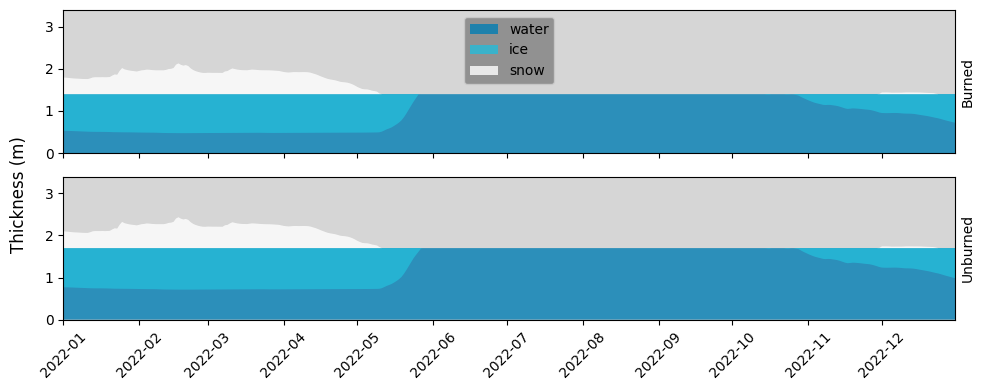

In [19]:
# plot layers

fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True, sharey=True)


axes[0].fill_between(layers_burned['Date'], layers_burned['water layer thickness, m'] - layers_burned['mean_mixed_layer_thickness'], layers_burned['water layer thickness, m'],  
                facecolor ='red', alpha = 0.8)
axes[0].fill_between(layers_burned['Date'], 0, layers_burned['water layer thickness, m'],  
                facecolor ='#027eb3', alpha = 0.8, label='water')
axes[0].fill_between(layers_burned['Date'], layers_burned['water layer thickness, m']-layers_burned['ice layer thickness,   m'], layers_burned['water layer thickness, m'],  
                facecolor ='#25bbd9', alpha = 0.8, label='ice')
axes[0].fill_between(layers_burned['Date'], layers_burned['water layer thickness, m'], layers_burned['snow layer thickness,  m'] + layers_burned['water layer thickness, m'],  
                facecolor ='white', alpha = 0.8, label='snow')
axes[0].fill_between(layers_burned['Date'], layers_burned['water layer thickness, m'] - layers_burned['mean_mixed_layer_thickness'], layers_burned['water layer thickness, m'],  
                facecolor ='red', alpha = 0.8)
axes[0].set_facecolor('#d6d6d6')
#axes[0].set_ylim(0,2.3)

axes[1].fill_between(layers_unburned['Date'], layers_unburned['water layer thickness, m'] - layers_unburned['mean_mixed_layer_thickness'], layers_unburned['water layer thickness, m'],  
                facecolor ='red', alpha = 0.8)
axes[1].fill_between(layers_unburned['Date'], 0, layers_unburned['water layer thickness, m'],  
                facecolor ='#027eb3', alpha = 0.8)
axes[1].fill_between(layers_unburned['Date'], layers_unburned['water layer thickness, m']-layers_unburned['ice layer thickness,   m'], layers_unburned['water layer thickness, m'],  
                facecolor ='#25bbd9', alpha = 0.8)
axes[1].fill_between(layers_unburned['Date'], layers_unburned['water layer thickness, m'], layers_unburned['snow layer thickness,  m'] + layers_unburned['water layer thickness, m'],  
                facecolor ='white', alpha = 0.8)
axes[1].fill_between(layers_unburned['Date'], layers_unburned['water layer thickness, m'] - layers_unburned['mean_mixed_layer_thickness'], layers_unburned['water layer thickness, m'],  
                facecolor ='red', alpha = 0.8)
axes[1].set_facecolor('#d6d6d6')
axes[0].legend(loc='upper center', facecolor = 'grey')

axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")

axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position("right")

plt.ylim(0, 3.4)
plt.xticks(rotation=45)
plt.xlim(pd.to_datetime('2022-01-01'),pd.to_datetime('2022-12-31'))
fig.supylabel('Thickness (m)')
fig.tight_layout()

plt.savefig('YKD_benchmark/figs/layers.jpg', dpi=300)

### Water Temperature Comparison

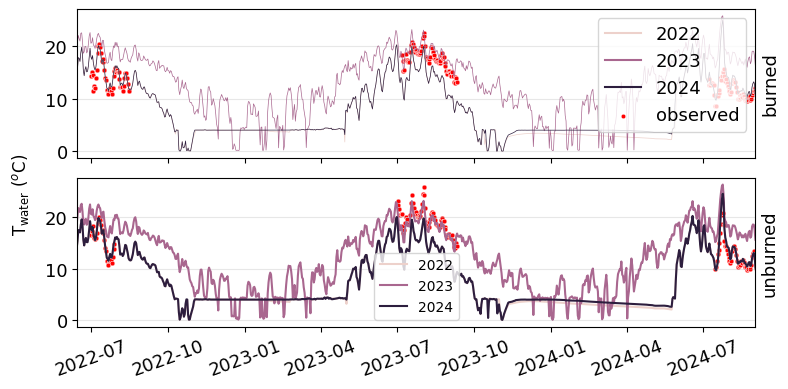

In [20]:
fig, axes = plt.subplots(2,1, figsize=(8,4), sharex=True)

sns.lineplot(data= burned_vars_df.loc[(burned_vars_df['t_water']!=-999)& (burned_vars_df['depth']==-1)], 
             x='Date', y='t_water', ax=axes[0], hue='sample', linewidth=0.5)

sns.scatterplot(data=burned_vars_df, x='Date', y='WaterTemp_meas_degC_mean', label='observed', ax=axes[0], color='red', s=10)
#sns.scatterplot(data=burned_vars_df, x='Date', y='WaterTemp_meas_degC', ax=axes[0])

sns.lineplot(data= unburned_vars_df.loc[(unburned_vars_df['t_water']!=-999)& (unburned_vars_df['depth']==-1)], 
             x='Date', y='t_water', ax=axes[1], hue='sample')
sns.scatterplot(data=unburned_vars_df, x='Date', y='WaterTemp_meas_degC_mean', ax=axes[1], color='red', s=10)
#sns.scatterplot(data=unburned_vars_df, x='Date', y='WaterTemp_meas_degC', ax=axes[1])

leg=axes[0].legend(fontsize=13)

axes[0].tick_params(axis='both', which='major', labelsize=13)
axes[1].tick_params(axis='both', which='major', labelsize=13)


axes[0].set_ylabel('burned', fontsize=13)
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)

axes[1].set_ylabel('unburned', fontsize=13)
axes[1].yaxis.set_label_position("right")
axes[1].grid(axis='y', alpha=0.3)

axes[1].set_xlabel('')

plt.xticks(rotation=20)
fig.supylabel('$\mathregular{T_{water}}$ ($^o$C)')
axes[1].set_xlim(pd.to_datetime('2022-06-15'), pd.to_datetime('2024-09-01'))
#axes[0].set_ylim(8,27)
#axes[1].set_ylim(8,27)
fig.tight_layout()

plt.savefig('YKD_benchmark/figs/twater.jpg', dpi=300)

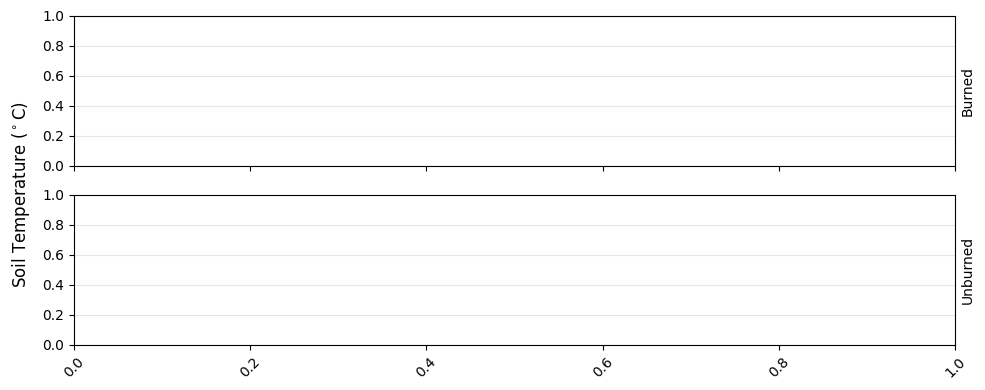

In [21]:
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_soil_temps_df.loc[(burned_soil_temps_df['sample']==0)&(burned_soil_temps_df['t_soil']!=-999)], 
             x='Date', y='t_soil', label='modeled', ax=axes[0], hue='depth', legend=False)

sns.lineplot(data= unburned_soil_temps_df.loc[(unburned_soil_temps_df['sample']==0)&(unburned_soil_temps_df['t_soil']!=-999)], 
             x='Date', y='t_soil', label='modeled', ax=axes[1], hue='depth', legend=False)

axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)

axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position("right")
axes[1].grid(axis='y', alpha=0.3)

axes[1].set_xlabel('')

plt.xticks(rotation=45)
fig.supylabel('Soil Temperature ($^\circ$C)')
fig.tight_layout()

#plt.savefig('YKD-SA/figures/SA_tsoil.jpg', dpi=300)

## Temperature profiles

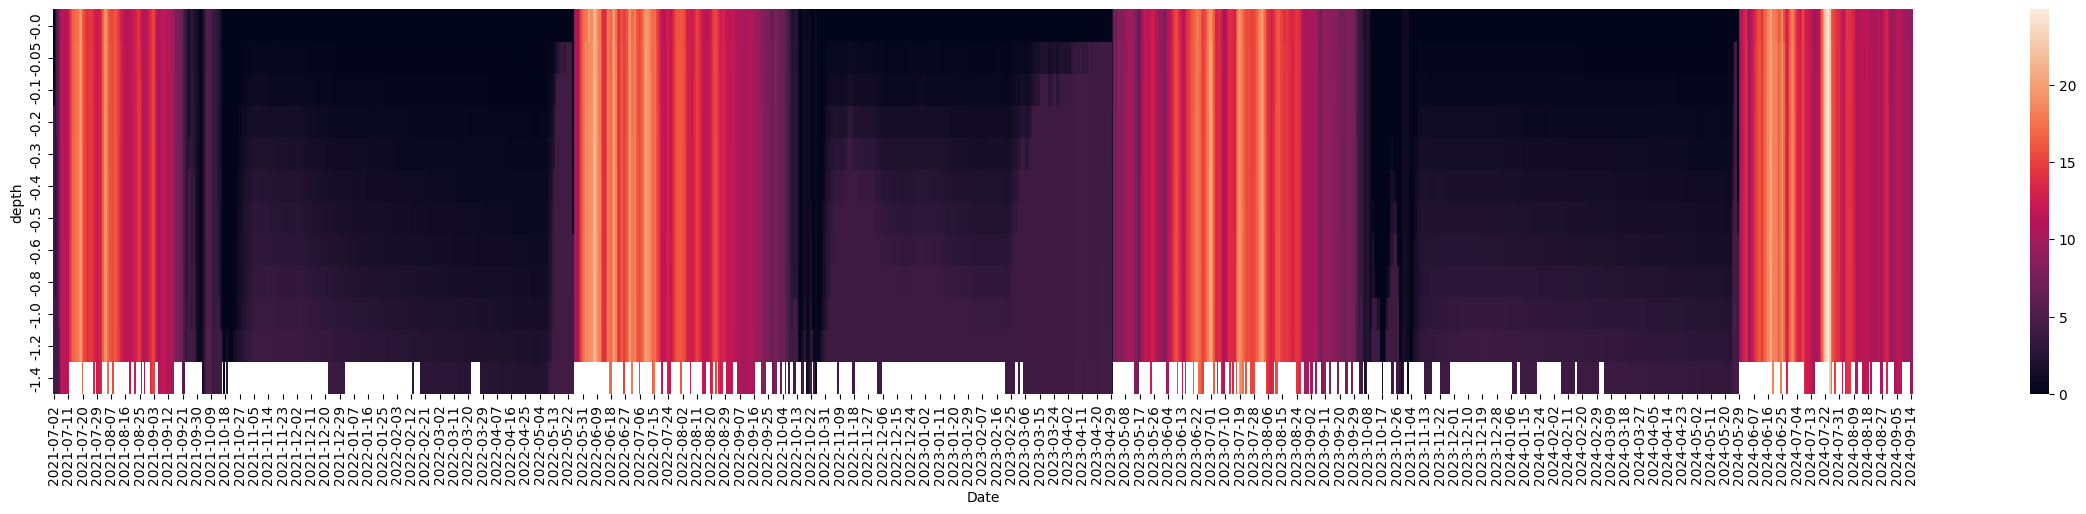

In [22]:
pd.plotting.register_matplotlib_converters()
burned_water_temps_df_filt=burned_vars_df.loc[(burned_vars_df['sample']==2022)&(burned_vars_df['t_water']!=-999)][['Date', 'depth', 't_water']].groupby(by=['Date', 'depth']).mean()
burned_water_temps_df_filt = burned_water_temps_df_filt.reset_index()
burned_water_temps_df_filt['Date'] = pd.to_datetime(burned_water_temps_df_filt['Date'])
burned_water_temps_df_filt['Date'] = burned_water_temps_df_filt['Date'].dt.date


pivot = burned_water_temps_df_filt.pivot(index='depth', columns='Date', values='t_water')
fig, ax = plt.subplots(1,1,figsize=(30,5))

sns.heatmap(pivot, cmap='rocket', ax=ax)

plt.gca().invert_yaxis()

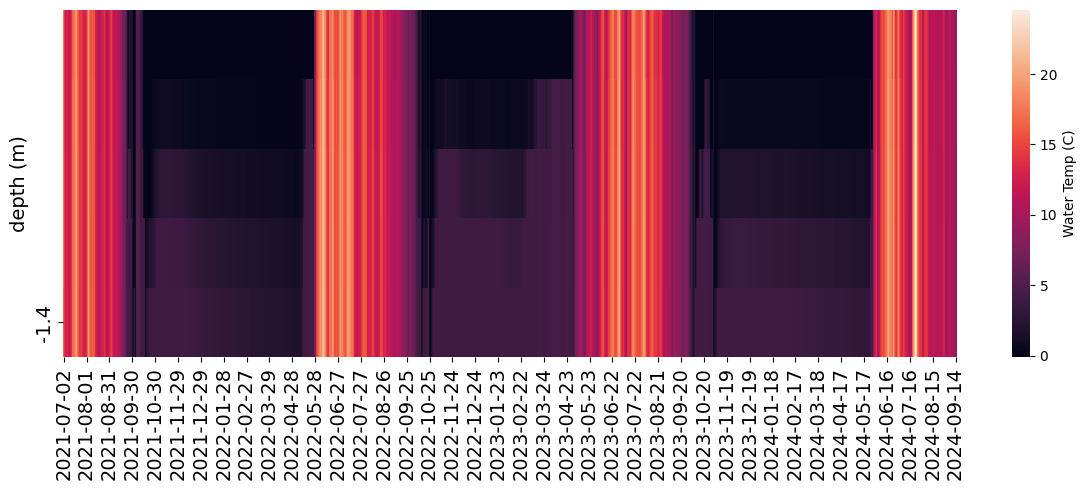

In [23]:
pd.plotting.register_matplotlib_converters()

unburned_water_temps_df_filt=unburned_vars_df.loc[(unburned_vars_df['sample']==2022)&(unburned_vars_df['t_water']!=-999)&(unburned_vars_df['depth']>-2.75)][['Date', 'depth', 't_water']].groupby(by=['Date', 'depth']).mean()
unburned_water_temps_df_filt = unburned_water_temps_df_filt.reset_index()
unburned_water_temps_df_filt['Date'] = pd.to_datetime(unburned_water_temps_df_filt['Date'])
unburned_water_temps_df_filt['Date'] = unburned_water_temps_df_filt['Date'].dt.date


pivot = unburned_water_temps_df_filt.pivot(index='depth', columns='Date', values='t_water')
fig, ax = plt.subplots(1,1,figsize=(12,5))

hmap = sns.heatmap(pivot, cmap='rocket', ax=ax, xticklabels=30,yticklabels=5, cbar_kws = {'label':'Water Temp (C)'})

plt.ylabel('depth (m)', fontsize=14)
plt.xlabel('')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)




plt.gca().invert_yaxis()
fig.tight_layout()
#plt.savefig('YKD-SA/figures/SA_twater_unburned_profile.jpg', dpi=300)

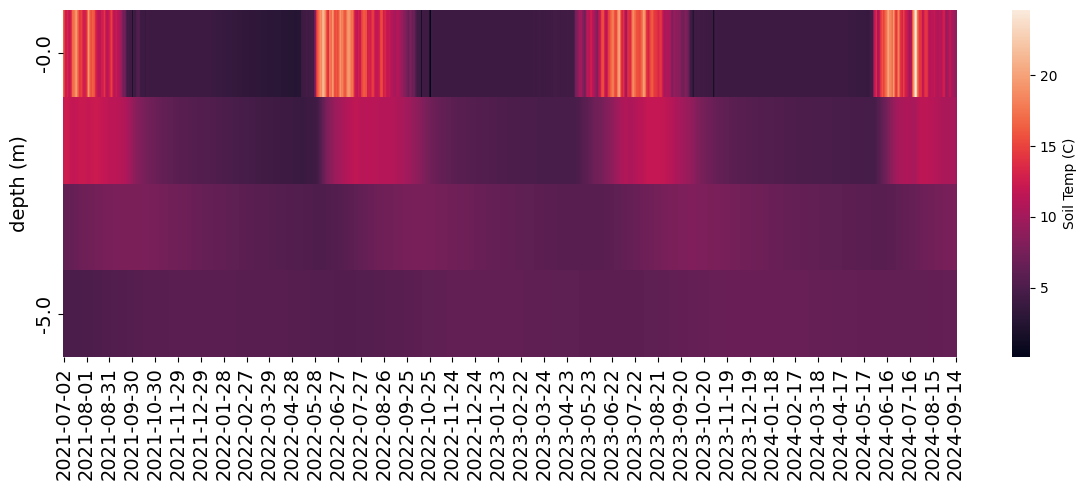

In [24]:
pd.plotting.register_matplotlib_converters()
unburned_soil_temps_df_filt=unburned_soil_temps_df.loc[(unburned_soil_temps_df['sample']==2022)&(unburned_soil_temps_df['t_soil']!=-999)][['Date', 'depth', 't_soil']]
unburned_soil_temps_df_filt['Date'] = pd.to_datetime(unburned_soil_temps_df_filt['Date'])
unburned_soil_temps_df_filt['Date'] = unburned_soil_temps_df_filt['Date'].dt.date

pivot = unburned_soil_temps_df_filt.pivot(index='depth', columns='Date', values='t_soil')
fig, ax = plt.subplots(1,1,figsize=(12,5))

sns.heatmap(pivot, cmap='rocket', ax=ax, xticklabels=30, yticklabels=3, cbar_kws = {'label':'Soil Temp (C)'})
plt.ylabel('depth (m)', fontsize=14)
plt.xlabel('')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.gca().invert_yaxis()

fig.tight_layout()
#plt.savefig('YKD-SA/figures/SA_tsoil_unburned_profile.jpg', dpi=300)



## Generate comparison statistics

In [25]:
def get_performance(df, model_var, obs_var):
    runs = []
    var_mae = []
    df.loc[df[obs_var]==-999, obs_var] = np.nan
    for run in df['sample'].unique():
        runs.append(run)

        if np.isnan(burned_vars_df.loc[(burned_vars_df['depth']==-1.0) & (burned_vars_df['sample']==run), 'CO2_umol_L'].max()):
            var_mae.append(np.nan)

        else:
            var_mae.append(mean_absolute_error(df.loc[(df['sample']==run) & (~df[obs_var].isna()), obs_var], df.loc[(df['sample']==run) & (~df[obs_var].isna()),model_var]))
    
    df_performance = pd.DataFrame({'sample': runs, f'{model_var}_mae': var_mae})

    return df_performance


In [26]:
df_twater_comp = get_performance(burned_vars_df.loc[(burned_vars_df['depth']==-1.0) & (burned_vars_df['Date'].dt.year==2023)], 't_water', 'WaterTemp_meas_degC_mean')
twater_top_10 = df_twater_comp.sort_values(by='t_water_mae')[:10]
twater_top = df_twater_comp.sort_values(by='t_water_mae')[:1]

df_twater_comp_ub = get_performance(unburned_vars_df.loc[(unburned_vars_df['depth']==-1.0) & (unburned_vars_df['Date'].dt.year==2022)], 't_water', 'WaterTemp_meas_degC_mean')
twater_top_10_ub = df_twater_comp_ub.sort_values(by='t_water_mae')[:10]
twater_top_ub = df_twater_comp_ub.sort_values(by='t_water_mae')[:1]


In [27]:
burned_sample_matrix.loc[burned_sample_matrix['sample'].isin(twater_top_10['sample']), :].min(axis=0)


sample   NaN
width    NaN
U        NaN
temp     NaN
CH4      NaN
DOC      NaN
dtype: float64

In [28]:
# CO2

df_co2_comp = get_performance(burned_vars_df.loc[(burned_vars_df['depth']==-1.0) & (burned_vars_df['Date'].dt.year==2024)], 'co2_water', 'CO2_umol_L')
co2_top_10 = df_co2_comp.sort_values(by='co2_water_mae')[:10]
co2_top = df_co2_comp.sort_values(by='co2_water_mae')[:1]

df_co2_comp_ub = get_performance(unburned_vars_df.loc[(unburned_vars_df['depth']==-1.0) & (unburned_vars_df['Date'].dt.year==2022)], 'co2_water', 'CO2_umol_L')
co2_top_10_ub = df_co2_comp_ub.sort_values(by='co2_water_mae')[:10]
co2_top_ub = df_co2_comp_ub.sort_values(by='co2_water_mae')[:1]

co2_data_burned = burned_vars_df.loc[(burned_vars_df['sample']==2022) & (burned_vars_df['t_water']!=-999) & (burned_vars_df['depth']==-1)][['Date', 'co2_water', 'CO2_umol_L', 'depth']].groupby(by='Date').mean().dropna()
co2_data_unburned = unburned_vars_df.loc[(unburned_vars_df['sample']==co2_top_ub['sample'].values[0]) & (unburned_vars_df['t_water']!=-999) & (unburned_vars_df['depth']==-1)][['Date', 'co2_water', 'CO2_umol_L', 'depth']].groupby(by='Date').mean().dropna()

In [29]:
burned_sample_matrix.loc[burned_sample_matrix['sample'].isin(co2_top_10['sample']), :].min(axis=0)

sample   NaN
width    NaN
U        NaN
temp     NaN
CH4      NaN
DOC      NaN
dtype: float64

In [30]:
burned_sample_matrix.loc[burned_sample_matrix['sample'].isin(co2_top_10['sample']), :].max(axis=0)


sample   NaN
width    NaN
U        NaN
temp     NaN
CH4      NaN
DOC      NaN
dtype: float64

In [31]:
# CH4
df_ch4_comp = get_performance(burned_vars_df.loc[burned_vars_df['depth']==-1.0], 'ch4_water', 'CH4_mol_m3')
ch4_top_10 = df_ch4_comp.sort_values(by='ch4_water_mae')[:10]
ch4_top = df_ch4_comp.sort_values(by='ch4_water_mae')[:1]

df_ch4_comp_ub = get_performance(unburned_vars_df.loc[unburned_vars_df['depth']==-1.0], 'ch4_water', 'CH4_mol_m3')
ch4_top_10_ub = df_ch4_comp_ub.sort_values(by='ch4_water_mae')[:10]
ch4_top_ub = df_ch4_comp_ub.sort_values(by='ch4_water_mae')[:1]

In [32]:
# O2
df_o2_comp = get_performance(burned_vars_df.loc[burned_vars_df['depth']==-1.0], 'o2_water', 'DO_mg_L')
o2_top_10 = df_o2_comp.sort_values(by='o2_water_mae')[:10]
o2_top = df_o2_comp.sort_values(by='o2_water_mae')[:1]

df_o2_comp_ub = get_performance(unburned_vars_df.loc[unburned_vars_df['depth']==-1.0], 'o2_water', 'DO_mg_L')
o2_top_10_ub = df_o2_comp_ub.sort_values(by='o2_water_mae')[:10]
o2_top_ub = df_o2_comp_ub.sort_values(by='o2_water_mae')[:1]

In [33]:
# Water temp.
water_temp_data_burned = burned_vars_df.loc[(burned_vars_df['sample']==2022) & (burned_vars_df['t_water']!=-999) & (burned_vars_df['depth']==-1)][['Date', 't_water', 'WaterTemp_meas_degC_mean', 'depth']].groupby(by='Date').mean().dropna()
water_temp_data_unburned = unburned_vars_df.loc[(unburned_vars_df['sample']==2022) & (unburned_vars_df['t_water']!=-999) & (unburned_vars_df['depth']==-1)][['Date', 't_water', 'WaterTemp_meas_degC_mean', 'depth']].groupby(by='Date').mean().dropna()

In [34]:
print('burned water temp r2: {}'.format(r2_score(water_temp_data_burned['WaterTemp_meas_degC_mean'], water_temp_data_burned['t_water'])))
print('burned water temp MAE: {}'.format(mean_absolute_error(water_temp_data_burned['WaterTemp_meas_degC_mean'], water_temp_data_burned['t_water'])))

print('unburned water temp r2: {}'.format(r2_score(water_temp_data_unburned['WaterTemp_meas_degC_mean'], water_temp_data_unburned['t_water'])))
print('unburned water temp MAE: {}'.format(mean_absolute_error(water_temp_data_unburned['WaterTemp_meas_degC_mean'], water_temp_data_unburned['t_water'])))

burned water temp r2: 0.17571052838068013
burned water temp MAE: 2.26271889149069
unburned water temp r2: 0.07108443717512858
unburned water temp MAE: 2.9286286816601605


In [35]:
print('burned mae:\nco2: {}\nch4: {}\no2: {}'.format(co2_top['co2_water_mae'].values[0], ch4_top['ch4_water_mae'].values[0], o2_top['o2_water_mae'].values[0]))
print('unburned mae:\nco2: {}\nch4: {}\no2: {}'.format(co2_top_ub['co2_water_mae'].values[0], ch4_top_ub['ch4_water_mae'].values[0], o2_top_ub['o2_water_mae'].values[0]))

burned mae:
co2: 29.26882745633106
ch4: 6.460346332064708
o2: 1.0970502052857147
unburned mae:
co2: 11.932196093514227
ch4: 0.12440028152019354
o2: 3.4629106581428566


In [36]:
print('burned water co2 r2: {}'.format(r2_score(co2_data_burned['CO2_umol_L'], co2_data_burned['co2_water'])))
print('unburned water co2 r2: {}'.format(r2_score(co2_data_unburned['CO2_umol_L'], co2_data_unburned['co2_water'])))

burned water co2 r2: -0.33557285468332765
unburned water co2 r2: -0.2349610689366075


In [37]:
s=29 #8, 20, 25, 27

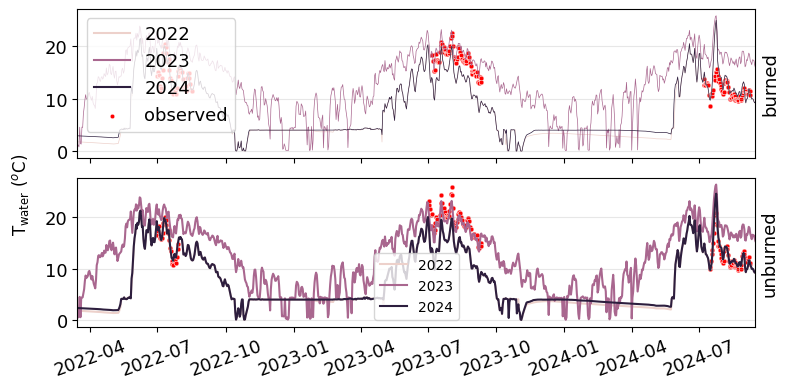

In [38]:
fig, axes = plt.subplots(2,1, figsize=(8,4), sharex=True)

sns.lineplot(data= burned_vars_df.loc[(burned_vars_df['t_water']!=-999)& (burned_vars_df['depth']==-1) & burned_vars_df['sample'].isin(twater_top_10['sample'])], 
             x='Date', y='t_water', ax=axes[0], hue='sample', linewidth=0.5)

#sns.lineplot(data= burned_vars_df.loc[(burned_vars_df['t_water']!=-999)& (burned_vars_df['depth']==-1) & (burned_vars_df['sample'].isin(twater_top['sample']))], 
#             x='Date', y='t_water', ax=axes[0], color='grey')

sns.scatterplot(data=burned_vars_df, x='Date', y='WaterTemp_meas_degC_mean', label='observed', ax=axes[0], color='red', s=10)


#sns.lineplot(data= unburned_vars_df.loc[(unburned_vars_df['t_water']!=-999)& (unburned_vars_df['depth']==-1) & unburned_vars_df['sample'].isin(twater_top_10_ub['sample'])], 
#             x='Date', y='t_water', ax=axes[1], hue='sample', linewidth=0.5)

sns.lineplot(data= unburned_vars_df.loc[(unburned_vars_df['t_water']!=-999)& (unburned_vars_df['depth']==-1) & unburned_vars_df['sample'].isin(twater_top_10_ub['sample'])], 
             x='Date', y='t_water', ax=axes[1], hue='sample')

sns.scatterplot(data=unburned_vars_df, x='Date', y='WaterTemp_meas_degC_mean', ax=axes[1], color='red', s=10)

leg=axes[0].legend(fontsize=13)

axes[0].tick_params(axis='both', which='major', labelsize=13)
axes[1].tick_params(axis='both', which='major', labelsize=13)


axes[0].set_ylabel('burned', fontsize=13)
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)

axes[1].set_ylabel('unburned', fontsize=13)
axes[1].yaxis.set_label_position("right")
axes[1].grid(axis='y', alpha=0.3)

axes[1].set_xlabel('')

plt.xticks(rotation=20)
fig.supylabel('$\mathregular{T_{water}}$ ($^o$C)')
axes[1].set_xlim(pd.to_datetime('2022-03-15'), pd.to_datetime('2024-09-15'))
#axes[0].set_ylim(8,27)
#axes[1].set_ylim(8,27)
fig.tight_layout()

plt.savefig('YKD_benchmark/figs/twater.jpg', dpi=300)

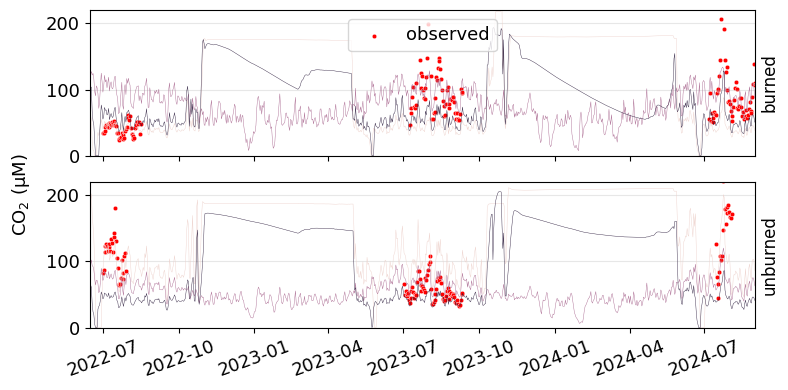

In [39]:
# Plot CO2 match
fig, axes = plt.subplots(2,1, figsize=(8,4), sharex=True)

sns.lineplot(data= burned_vars_df[(burned_vars_df['co2_water']!=-999 ) & (burned_vars_df['depth']==-1)], 
             x='Date', y='co2_water', hue = 'sample', legend=False, linewidth=0.3, ax=axes[0])

#sns.lineplot(data= burned_vars_df[(burned_vars_df['co2_water']!=-999 )  & (burned_vars_df['depth']==-1) & burned_vars_df['sample'].isin(co2_top['sample'])], 
#             x='Date', y='co2_water', label='modeled', color='grey', ax=axes[0])

#sns.lineplot(data= burned_vars_df[(burned_vars_df['co2_water']!=-999 ) & (burned_vars_df['depth']==-1)], 
#             x='Date', y='co2_water', hue = 'sample', legend=False, linewidth=0.3, ax=axes[0])

#sns.lineplot(data= burned_vars_df[(burned_vars_df['co2_water']!=-999 ) & (burned_vars_df['depth']==-1)& (burned_vars_df['sample']==29)], 
#             x='Date', y='co2_water', hue = 'sample', legend=False, linewidth=0.3, ax=axes[0])


sns.scatterplot(data= co2_obs.loc[co2_obs['pond']=='burned'], x='Date', y='CO2_umol_L', label='observed', color='red', ax=axes[0], s=10)

axes[0].set_ylabel('burned', fontsize=12)
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='both', which='major', labelsize=13)

#sns.lineplot(data= unburned_vars_df[(unburned_vars_df['co2_water']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['sample'].isin(co2_top_10_ub['sample'])], 
#             x='Date', y='co2_water', hue = 'sample', legend=False, linewidth=0.3, ax=axes[1])
sns.lineplot(data= unburned_vars_df[(unburned_vars_df['co2_water']!=-999 ) & (unburned_vars_df['depth']==-1)], 
             x='Date', y='co2_water', hue = 'sample', legend=False, linewidth=0.3, ax=axes[1])
sns.scatterplot(data= co2_obs.loc[co2_obs['pond']=='unburned'], x='Date', y='CO2_umol_L', color='red', ax=axes[1], s=10)

plt.xticks(rotation=20)
#axes[0].set_ylim(0,180)
leg=axes[0].legend(fontsize=13)
axes[1].set_ylabel('unburned', fontsize=12)
axes[1].yaxis.set_label_position('right')
axes[1].grid(axis='y', alpha=0.3)

axes[1].set_xlabel('')
axes[1].tick_params(axis='both', which='major', labelsize=13)

fig.supylabel(u'$\mathregular{CO_2}$ (\u03bcM)', fontsize=13)




axes[0].set_ylim(0,220)
axes[1].set_ylim(0,220)
axes[1].set_xlim(pd.to_datetime('2022-06-15'), pd.to_datetime('2024-09-01'))

fig.tight_layout()
plt.savefig('YKD_benchmark/figs/CO2.jpg', dpi=300)

## Water sample data comparison

In [40]:
# Generate box plot data for water sample comparisons
burned_sample_comp = burned_vars_df.loc[(~burned_vars_df['CH4_mol_m3'].isna()) & (burned_vars_df['depth']==-1)][['Date', 'ch4_water', 'o2_water', 'DO_mg_L', 'CH4_mol_m3', 'depth']].groupby(by='Date').mean()
unburned_sample_comp = unburned_vars_df.loc[(~unburned_vars_df['CH4_mol_m3'].isna()) & (unburned_vars_df['depth']==-1)][['Date', 'ch4_water', 'o2_water', 'DO_mg_L', 'CH4_mol_m3', 'depth']].groupby(by='Date').mean()
burned_sample_comp['pond'] = 'burned' 
unburned_sample_comp['pond'] = 'unburned'
sample_comp = pd.concat([burned_sample_comp, unburned_sample_comp]).reset_index()
sample_comp_melt=pd.melt(sample_comp, id_vars=['Date', 'pond'])

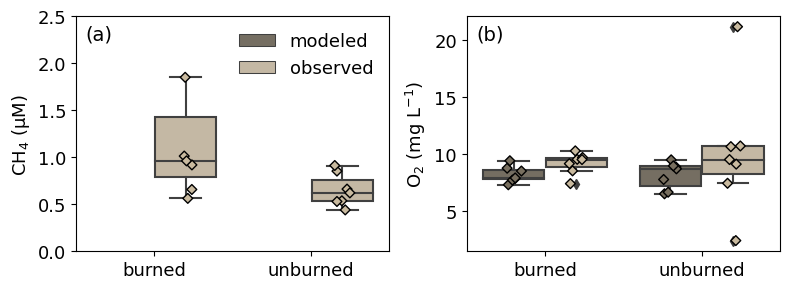

In [41]:
palette= sns.color_palette(['#786F5F', '#C9BA9F'])

fig, axes = plt.subplots(1,2, figsize=(8,3))

sns.boxplot(data=sample_comp_melt.loc[(sample_comp_melt['variable'] == 'ch4_water') | (sample_comp_melt['variable'] == 'CH4_mol_m3')], 
            x='pond', y='value', hue='variable', palette=palette, ax=axes[0])
sns.stripplot(data=sample_comp_melt.loc[(sample_comp_melt['variable'] == 'ch4_water') | (sample_comp_melt['variable'] == 'CH4_mol_m3')], 
            x='pond', y='value', hue='variable', dodge=True, marker="D", edgecolor="black", linewidth=1, legend=False, palette=palette, ax=axes[0])
axes[0].set_ylim(0,4)
L=axes[0].legend(frameon=False, fontsize=13)
L.get_texts()[0].set_text('modeled')
L.get_texts()[1].set_text('observed')

axes[0].set_ylabel(u'$\mathregular{CH_4}$ (\u03bcM)', fontsize=13)
axes[0].set_ylim(0,2.5)
axes[0].set_xlabel('')
axes[0].tick_params(axis='both', which='major', labelsize=13)
axes[0].text(0.03, 0.9,'(a)', transform=axes[0].transAxes, fontsize=14)

sns.boxplot(data=sample_comp_melt.loc[(sample_comp_melt['variable'] == 'o2_water') | (sample_comp_melt['variable'] == 'DO_mg_L')], 
            x='pond', y='value', hue='variable', palette=palette, ax=axes[1])
sns.stripplot(data=sample_comp_melt.loc[(sample_comp_melt['variable'] == 'o2_water') | (sample_comp_melt['variable'] == 'DO_mg_L')], 
            x='pond', y='value', hue='variable', dodge=True, marker="D", edgecolor="black", linewidth=1, palette=palette, ax=axes[1])

L2=axes[1].legend()
L2.remove()


axes[1].set_ylabel('$\mathregular{O_2}$ (mg $\mathregular{L^{-1}}$)', fontsize=13)
axes[1].set_xlabel('')
axes[1].tick_params(axis='both', which='major', labelsize=13)
axes[1].text(0.03, 0.9,'(b)', transform=axes[1].transAxes, fontsize=14)

fig.tight_layout()

plt.savefig('YKD_benchmark/figs/CH4_O2.jpg', dpi=300)

## Other biogeochemical properties - for monitoring

(19158.0, 19236.0)

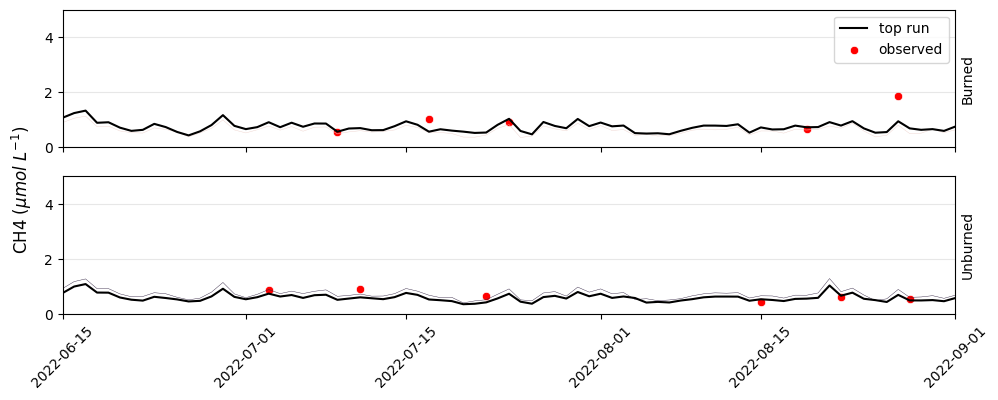

In [42]:
# CH4 concentration

fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data = burned_vars_df[(burned_vars_df['ch4_water']!=-999 ) & (burned_vars_df['depth']==-1)], 
             x='Date', y='ch4_water', hue = 'sample', legend=False, linewidth=0.3, ax=axes[0])
sns.lineplot(data= burned_vars_df[(burned_vars_df['ch4_water']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['sample'].isin(ch4_top['sample'])], 
             x='Date', y='ch4_water', label='top run', color='black', ax=axes[0])
sns.scatterplot(data=ch4_obs[ch4_obs['pond']=='15B_FP'], x='Date', y='CH4_mol_m3', label='observed', color='red', ax=axes[0])

axes[0].set_ylim(0,5)
axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)

sns.lineplot(data= unburned_vars_df[(unburned_vars_df['ch4_water']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['sample'].isin(co2_top_10_ub['sample'])], 
             x='Date', y='ch4_water', hue = 'sample', legend=False, linewidth=0.3, ax=axes[1])
sns.lineplot(data= unburned_vars_df[(unburned_vars_df['ch4_water']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['sample'].isin(co2_top_ub['sample'])], 
             x='Date', y='ch4_water',  color='black', legend=False, ax=axes[1])
sns.scatterplot(data=ch4_obs[ch4_obs['pond']=='UB_FP'], x='Date', y='CH4_mol_m3', color='red', ax=axes[1])

axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position("right")
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xlabel('')
axes[1].set_ylim(0,5.0)

plt.xticks(rotation=45)
fig.supylabel(u'CH4 ($\u03bcmol$ $L^{-1}$)')
fig.tight_layout()
axes[1].set_xlim(pd.to_datetime('2022-06-15'), pd.to_datetime('2022-09-01'))
#plt.savefig('YKD-SA/figures/SA_ch4.jpg', dpi=300)

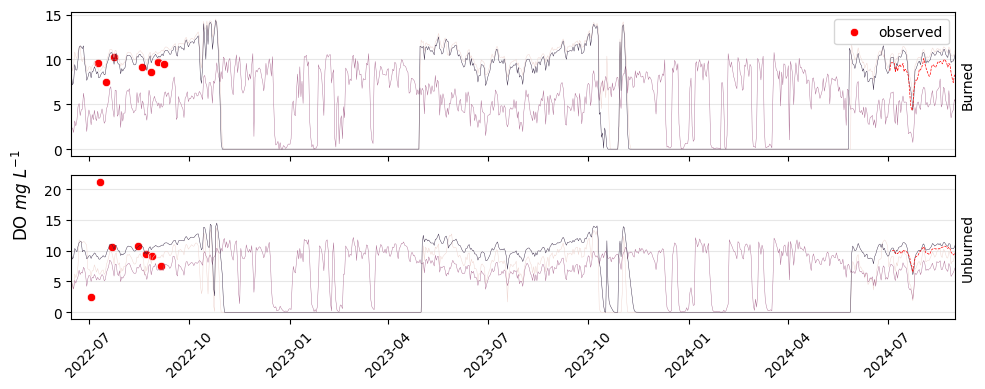

In [43]:
# O2 concentration

fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_vars_df[(burned_vars_df['ch4_water']!=-999 ) & (burned_vars_df['depth']==-1.0)], 
             x='Date', y='o2_water', hue = 'sample', legend=False, linewidth=0.3, ax=axes[0])

sns.scatterplot(data=ch4_obs[ch4_obs['pond']=='15B_FP'], x='Date', y='DO_mg_L', label='observed', color='red', ax=axes[0])
sns.lineplot(data=do_2024[do_2024['pond']=='burned'], x='Date', y='DO_mgL', color='red', linestyle='--', linewidth=0.5, ax=axes[0])


axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)

sns.lineplot(data= unburned_vars_df[(unburned_vars_df['ch4_water']!=-999 ) & (unburned_vars_df['depth']==-1.0) & unburned_vars_df['sample'].isin(co2_top_10_ub['sample'])],
             x='Date', y='o2_water', hue = 'sample', legend=False, linewidth=0.3, ax=axes[1])
sns.scatterplot(data=ch4_obs[ch4_obs['pond']=='UB_FP'], x='Date', y='DO_mg_L', color='red', ax=axes[1])
sns.lineplot(data=do_2024[do_2024['pond']=='unburned'], x='Date', y='DO_mgL', color='red', linestyle='--', linewidth=0.5, ax=axes[1])

axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position("right")
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xlabel('')

plt.xticks(rotation=45)
fig.supylabel('DO $mg$ $L^{-1}$')
axes[1].set_xlim(pd.to_datetime('2022-06-15'), pd.to_datetime('2024-09-01'))
fig.tight_layout()


#plt.savefig('YKD-SA/figures/SA_do.jpg', dpi=300)
#plt.ylim(0,10)

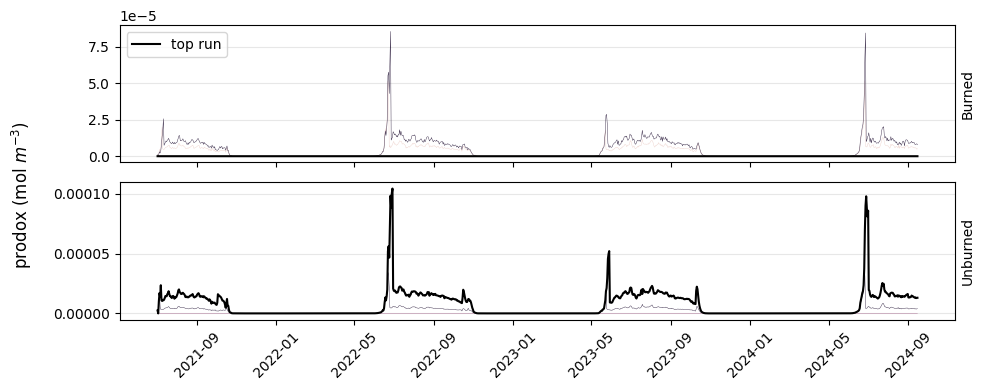

In [44]:
#Prodox - photosynthesis

fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_vars_df[(burned_vars_df['prodox']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['sample'].isin(co2_top_10['sample'])], 
             x='Date', y='prodox', hue = 'sample', legend=False, linewidth=0.3, ax=axes[0])

sns.lineplot(data= burned_vars_df[(burned_vars_df['prodox']!=-999 )  & (burned_vars_df['depth']==-1) & burned_vars_df['sample'].isin(co2_top['sample'])], 
             x='Date', y='prodox', label='top run', color='black', ax=axes[0])

axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)

sns.lineplot(data= unburned_vars_df[(unburned_vars_df['prodox']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['sample'].isin(co2_top_10_ub['sample'])], 
             x='Date', y='prodox', hue = 'sample', legend=False, linewidth=0.3, ax=axes[1])
sns.lineplot(data= unburned_vars_df[(unburned_vars_df['prodox']!=-999 )  & (unburned_vars_df['depth']==-1) & unburned_vars_df['sample'].isin(co2_top_ub['sample'])], 
             x='Date', y='prodox', color='black', ax=axes[1])

plt.xticks(rotation=45)

axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position('right')
axes[1].grid(axis='y', alpha=0.3)

axes[1].set_xlabel('')
#axes[1].set_ylim(0,1e-5)
fig.supylabel(u'prodox (mol $m^{-3}$)')
fig.tight_layout()

#plt.savefig('YKD-SA/figures/SA_prodox.jpg', dpi=300)

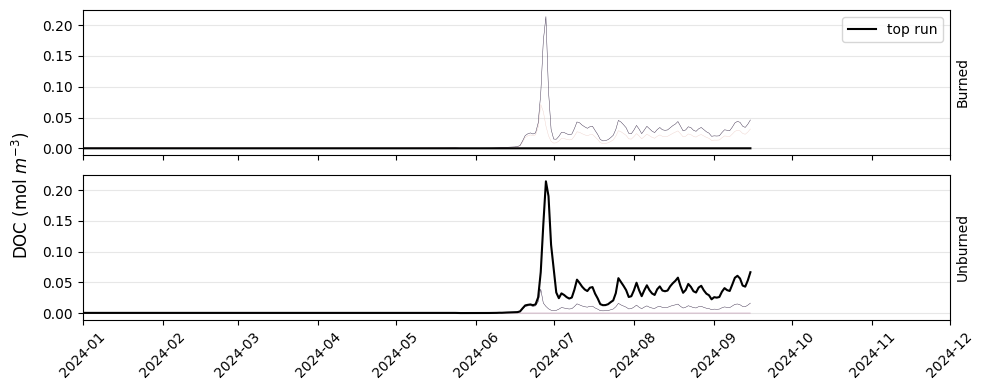

In [45]:
#DOC
#LAKE units in mol/m3
#mol/m3 DOC = mg/L DOC * 1e-3 / (12 * 1e-3)
#28 mg/l DOC = 2.33 mol/m3 DOC

fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_vars_df[(burned_vars_df['doc_water']!=-999 ) & (burned_vars_df['depth']==-1)], 
             x='Date', y='doc_water', hue = 'sample', legend=False, linewidth=0.3, ax=axes[0])

sns.lineplot(data= burned_vars_df[(burned_vars_df['doc_water']!=-999 )  & (burned_vars_df['depth']==-1) & burned_vars_df['sample'].isin(co2_top['sample'])], 
             x='Date', y='doc_water', label='top run', color='black', ax=axes[0])

axes[0].set_ylabel('Burned')
axes[0].yaxis.set_label_position("right")
axes[0].grid(axis='y', alpha=0.3)

sns.lineplot(data= unburned_vars_df[(unburned_vars_df['doc_water']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['sample'].isin(co2_top_10_ub['sample'])], 
             x='Date', y='doc_water', hue = 'sample', legend=False, linewidth=0.3, ax=axes[1])
sns.lineplot(data= unburned_vars_df[(unburned_vars_df['doc_water']!=-999 )  & (unburned_vars_df['depth']==-1) & unburned_vars_df['sample'].isin(co2_top_ub['sample'])], 
             x='Date', y='doc_water', color='black', ax=axes[1])

plt.xticks(rotation=45)
axes[0].set_xlim(pd.to_datetime('2024-01-01'),pd.to_datetime('2024-12-01'))

axes[1].set_ylabel('Unburned')
axes[1].yaxis.set_label_position('right')
axes[1].grid(axis='y', alpha=0.3)

axes[1].set_xlabel('')

fig.supylabel(u'DOC (mol $m^{-3}$)')
fig.tight_layout()

plt.savefig('YKD-SA/figures/SA_doc.jpg', dpi=300)

In [46]:
poc_mol_m3_to_mg_L = 30

(array([18871., 18993., 19113., 19236., 19358., 19478., 19601., 19723.,
        19844., 19967.]),
 [Text(18871.0, 0, '2021-09'),
  Text(18993.0, 0, '2022-01'),
  Text(19113.0, 0, '2022-05'),
  Text(19236.0, 0, '2022-09'),
  Text(19358.0, 0, '2023-01'),
  Text(19478.0, 0, '2023-05'),
  Text(19601.0, 0, '2023-09'),
  Text(19723.0, 0, '2024-01'),
  Text(19844.0, 0, '2024-05'),
  Text(19967.0, 0, '2024-09')])

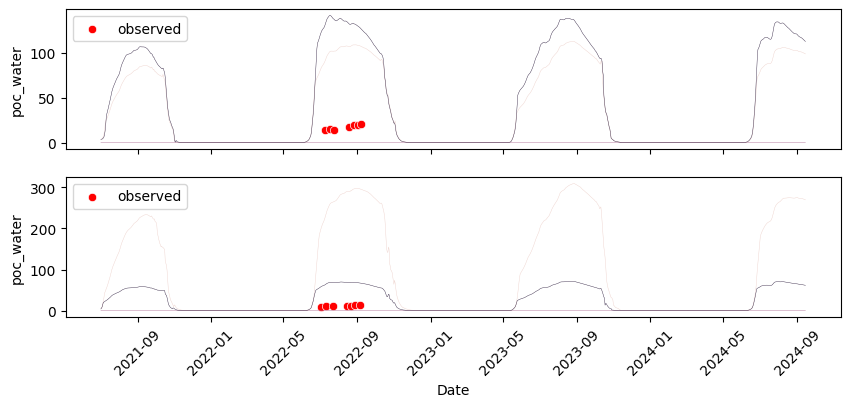

In [47]:
# POCL
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_vars_df[(burned_vars_df['pocl_water']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['sample'].isin(o2_top_10['sample'])], x='Date', y=burned_vars_df['poc_water']*poc_mol_m3_to_mg_L, hue = 'sample', legend=False, linewidth=0.3, ax=axes[0])

sns.scatterplot(data=ch4_obs[ch4_obs['pond']=='15B_FP'], x='Date', y='TOC (mg/L)', label='observed', color='red', ax=axes[0])
plt.xticks(rotation=45)

sns.lineplot(data=unburned_vars_df[(unburned_vars_df['pocl_water']!=-999 ) & (unburned_vars_df['depth']==-1) & unburned_vars_df['sample'].isin(o2_top_10_ub['sample'])], x='Date', y=unburned_vars_df['poc_water']*poc_mol_m3_to_mg_L, hue = 'sample', legend=False, linewidth=0.3, ax=axes[1])

sns.scatterplot(data=ch4_obs[ch4_obs['pond']=='UB_FP'], x='Date', y='TOC (mg/L)', label='observed', color='red', ax=axes[1])

plt.xticks(rotation=45)

Text(0, 0.5, 'POCL (mg/L)')

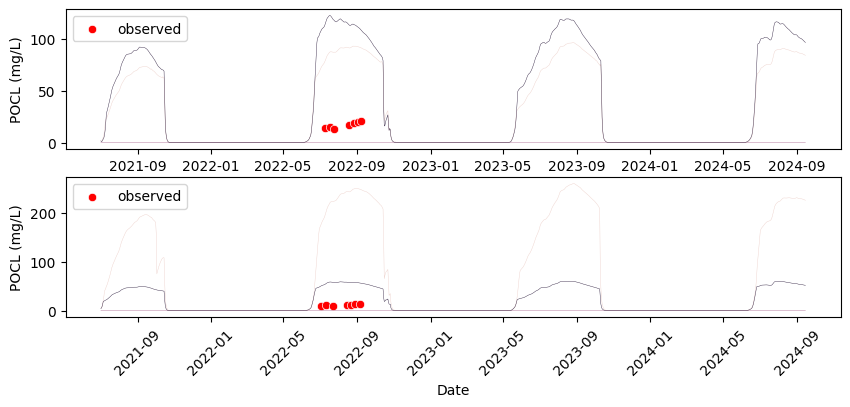

In [48]:
# POCD
fig, axes = plt.subplots(2,1, figsize=(10,4))

sns.lineplot(data = burned_vars_df[(burned_vars_df['pocd_water']!=-999 ) & (burned_vars_df['depth']==-1.0) & burned_vars_df['sample'].isin(o2_top_10['sample'])], x='Date', y=burned_vars_df['pocl_water']*poc_mol_m3_to_mg_L, hue = 'sample', legend=False, linewidth=0.3, ax=axes[0])

sns.scatterplot(data = ch4_obs[ch4_obs['pond']=='15B_FP'], x='Date', y='TOC (mg/L)', label='observed', color='red', ax=axes[0])
plt.xticks(rotation=45)

sns.lineplot(data = unburned_vars_df[(unburned_vars_df['pocd_water']!=-999 ) & (unburned_vars_df['depth']==-1.0) & unburned_vars_df['sample'].isin(co2_top_10_ub['sample'])], x='Date', y=unburned_vars_df['pocl_water']*poc_mol_m3_to_mg_L, hue = 'sample', legend=False, linewidth=0.3, ax=axes[1])

sns.scatterplot(data = ch4_obs[ch4_obs['pond']=='UB_FP'], x='Date', y='TOC (mg/L)', label='observed', color='red', ax=axes[1])
plt.xticks(rotation=45)

axes[0].set_ylabel('POCL (mg/L)')
axes[1].set_ylabel('POCL (mg/L)')

## CH4 data visualization

(0.0, 1.0)

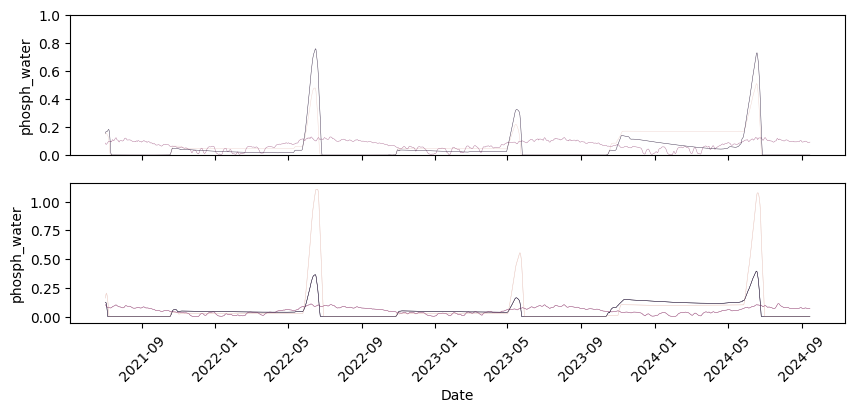

In [49]:
# Phosphorus
# Lougheed et al., 2015: Total phosphorus (TP):25-83 ug/L , DOC: 18 - 37 mg/L, extinction coefficient 3-6.6 /m, CHLa: 0.7-3.0 ug/L
# LAKE units in mol/m3
# 50 ug/L P = 0.0004 mol/m3 P
# mol/m3 P = (ug/L P) * 50 / (1e6*123.88*1e-3)

fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_vars_df[(burned_vars_df['phosph_water']!=-999 ) & (burned_vars_df['depth']==-1.0) & burned_vars_df['sample'].isin(co2_top_10['sample'])], x='Date', y='phosph_water', hue = 'sample', legend=False, linewidth=0.3, ax=axes[0])
plt.xticks(rotation=45)


sns.lineplot(data= unburned_vars_df[(unburned_vars_df['phosph_water']!=-999 ) & (unburned_vars_df['depth']==-1.0) & unburned_vars_df['sample'].isin(co2_top_10_ub['sample'])], x='Date', y='phosph_water', hue = 'sample', legend=False, linewidth=0.3, ax=axes[1])
sns.lineplot(data= unburned_vars_df[(unburned_vars_df['phosph_water']!=-999 ) & (unburned_vars_df['depth']==-1.0) & unburned_vars_df['sample'].isin(co2_top_10['sample'])], x='Date', y='phosph_water', hue = 'sample', legend=False, linewidth=0.3, ax=axes[1])
plt.xticks(rotation=45)

#mg/l phosph
axes[0].set_ylim(0,1)
#axes[1].set_ylim(0,0.001)

(array([18871., 18993., 19113., 19236., 19358., 19478., 19601., 19723.,
        19844., 19967.]),
 [Text(18871.0, 0, '2021-09'),
  Text(18993.0, 0, '2022-01'),
  Text(19113.0, 0, '2022-05'),
  Text(19236.0, 0, '2022-09'),
  Text(19358.0, 0, '2023-01'),
  Text(19478.0, 0, '2023-05'),
  Text(19601.0, 0, '2023-09'),
  Text(19723.0, 0, '2024-01'),
  Text(19844.0, 0, '2024-05'),
  Text(19967.0, 0, '2024-09')])

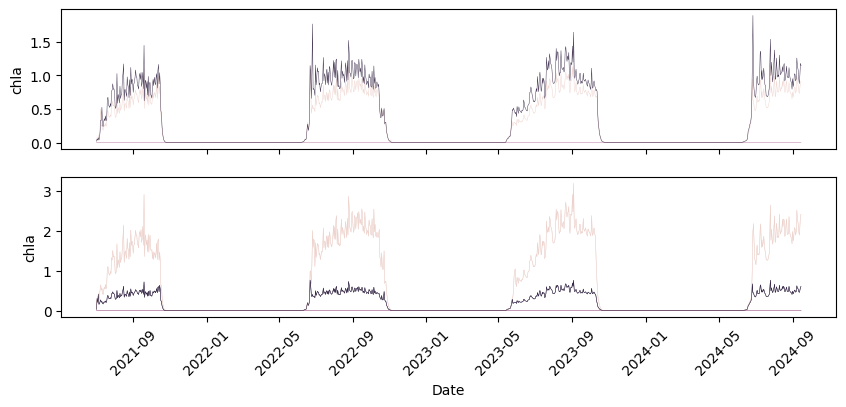

In [50]:
# Chla
# units in mg/m3 == ug/L
# 3ug/L = 0.003 mg/L
fig, axes = plt.subplots(2,1, figsize=(10,4), sharex=True)

sns.lineplot(data= burned_vars_df[(burned_vars_df['chla']!=-999 ) & (burned_vars_df['depth']==-1.0) & burned_vars_df['sample'].isin(co2_top_10['sample'])], x='Date', y='chla', hue = 'sample', legend=False, linewidth=0.3, ax=axes[0])
plt.xticks(rotation=45)


sns.lineplot(data= unburned_vars_df[(unburned_vars_df['chla']!=-999 ) & (unburned_vars_df['depth']==-1.0) & unburned_vars_df['sample'].isin(co2_top_10_ub['sample'])], x='Date', y='chla', hue = 'sample', legend=False, linewidth=0.3, ax=axes[1])
sns.lineplot(data= unburned_vars_df[(unburned_vars_df['chla']!=-999 ) & (unburned_vars_df['depth']==-1.0) & unburned_vars_df['sample'].isin(co2_top_10['sample'])], x='Date', y='chla', hue = 'sample', legend=False, linewidth=0.3, ax=axes[1])
plt.xticks(rotation=45)

#mg/l phosph
#axes[0].set_ylim(0,0.0005)
#axes[1].set_ylim(0,0.0005)

In [51]:

burned_methane_df['co2_turb_flux_mg/(m**2*day)'] = burned_methane_df['co2_turb_flux_mol/(m**2*s)'] * 44 * 1000 * 86400
unburned_methane_df['co2_turb_flux_mg/(m**2*day)'] = unburned_methane_df['co2_turb_flux_mol/(m**2*s)'] * 44 * 1000 * 86400


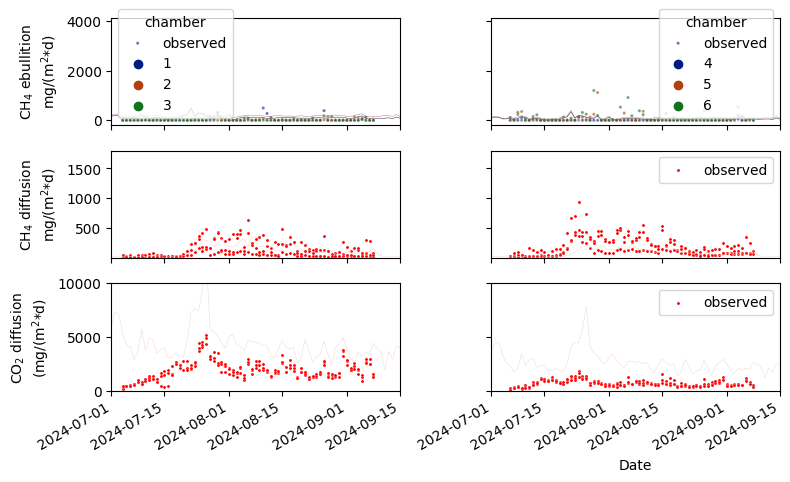

In [52]:
auto_fluxes = auto_fluxes.rename(columns={'Date':'date'})
fig, axes = plt.subplots(3,2, sharex=True, sharey='row', figsize=(8,5))

sns.lineplot(data= burned_methane_df, x='Date', y='methane_ebul_mg/(m**2*day)', hue = 'sample', legend=False, linewidth=0.3, ax=axes[0,0])
sns.scatterplot(data=auto_fluxes[auto_fluxes['pond']=='burned'], x='date', y='mg_m2_d_ebul_ch4', label='observed', 
                hue='chamber', ax=axes[0,0], palette='dark', alpha=0.6, s=5)

sns.lineplot(data= burned_methane_df[burned_methane_df['sample']==2024], x='Date', y='methane_turb_flux_mg/(m**2*day)', hue = 'sample', legend=False, linewidth=0.3, ax=axes[1,0])
sns.scatterplot(data=auto_fluxes[auto_fluxes['pond']=='burned'], x='date', y='mg_m2_d_diff_ch4', label='observed', 
                color='red', ax=axes[1,0], s=5)

sns.lineplot(data= burned_methane_df[burned_methane_df['sample']==2024], x='Date', y='co2_turb_flux_mg/(m**2*day)', hue = 'sample', legend=False, linewidth=0.3, ax=axes[2,0])
sns.scatterplot(data=auto_fluxes[auto_fluxes['pond']=='burned'], x='date', y='mg_m2_d_diff_co2', label='observed', 
                color='red', ax=axes[2,0], s=5)

sns.lineplot(data= unburned_methane_df, x='Date', y='methane_ebul_mg/(m**2*day)', hue = 'sample', legend=False, linewidth=0.3, ax=axes[0,1])
sns.scatterplot(data=auto_fluxes[auto_fluxes['pond']=='unburned'], x='date', y='mg_m2_d_ebul_ch4', label='observed', 
                hue='chamber', ax=axes[0,1], palette='dark', alpha=0.6, s=5)

sns.lineplot(data= unburned_methane_df[unburned_methane_df['sample']==2024], x='Date', y='methane_turb_flux_mg/(m**2*day)', hue = 'sample', legend=False, linewidth=0.3, ax=axes[1,1])
sns.scatterplot(data=auto_fluxes[auto_fluxes['pond']=='unburned'], x='date', y='mg_m2_d_diff_ch4', label='observed', 
                color='red', ax=axes[1,1], s=5)

sns.lineplot(data= unburned_methane_df[unburned_methane_df['sample']==2024], x='Date', y='co2_turb_flux_mg/(m**2*day)', hue = 'sample', legend=False, linewidth=0.3, ax=axes[2,1])
sns.scatterplot(data=auto_fluxes[auto_fluxes['pond']=='unburned'], x='date', y='mg_m2_d_diff_co2', label='observed', 
                color='red', ax=axes[2,1], s=5)

axes[0,0].set_xlim(pd.to_datetime('2024-07-01'), pd.to_datetime('2024-09-15'))
axes[1,0].set_xlim(pd.to_datetime('2024-07-01'), pd.to_datetime('2024-09-15'))
axes[2,0].set_xlim(pd.to_datetime('2024-07-01'), pd.to_datetime('2024-09-15'))

axes[2,0].legend().remove()
axes[1,0].set_ylim(1,1800)
axes[2,0].set_ylim(0,10000)

axes[0,0].set_ylabel('CH$_4$ ebullition\nmg/(m$^2$*d)')
axes[1,0].set_ylabel('CH$_4$ diffusion\nmg/(m$^2$*d)')
axes[2,0].set_ylabel('CO$_2$ diffusion\n(mg/(m$^2$*d)')

# Add custom legend
#axes[0,0].legend(handles=legend_elements, frameon=True, fontsize=12, 
#               loc='upper left', bbox_to_anchor=(0.7, 1.05))
axes[1,0].legend().remove()


#axes[1].set_yscale('log')
axes[2,0].set_xlabel('')
fig.autofmt_xdate()
fig.tight_layout()
plt.savefig('YKD_benchmark/figs/auto_fluxes.jpg', dpi=300)


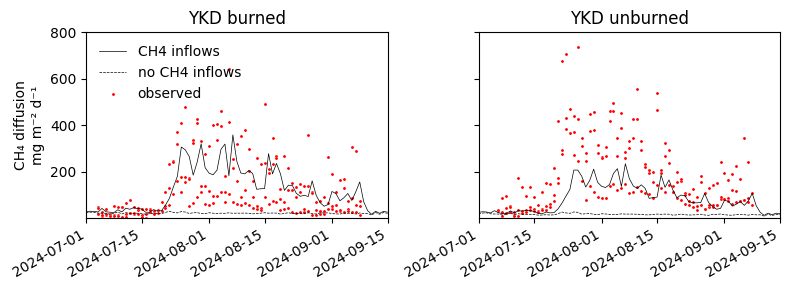

In [67]:
auto_fluxes = auto_fluxes.rename(columns={'Date':'date'})
fig, axes = plt.subplots(1,2, sharex=True, sharey='row', figsize=(8,3))

sns.lineplot(data= burned_methane_df[burned_methane_df['sample']==2024], x='Date', y='methane_turb_flux_mg/(m**2*day)', color='black', label='CH4 inflows', linewidth=0.5, ax=axes[0])
sns.lineplot(data= burned_methane_df[burned_methane_df['sample']==2022], x='Date', y='methane_turb_flux_mg/(m**2*day)', color='black', label='no CH4 inflows', linewidth=0.5, ax=axes[0], linestyle='--')
sns.scatterplot(data=auto_fluxes[auto_fluxes['pond']=='burned'], x='date', y='mg_m2_d_diff_ch4', label='observed', color='red', ax=axes[0], s=5)

sns.lineplot(data= unburned_methane_df[unburned_methane_df['sample']==2024], x='Date', y='methane_turb_flux_mg/(m**2*day)', color='black', legend=False, linewidth=0.5, ax=axes[1])
sns.lineplot(data= unburned_methane_df[unburned_methane_df['sample']==2022], x='Date', y='methane_turb_flux_mg/(m**2*day)', color='black', legend=False, linewidth=0.5, ax=axes[1], linestyle='--')
sns.scatterplot(data=auto_fluxes[auto_fluxes['pond']=='unburned'], x='date', y='mg_m2_d_diff_ch4', legend=False, color='red', ax=axes[1], s=5)

axes[0].set_xlim(pd.to_datetime('2024-07-01'), pd.to_datetime('2024-09-15'))
axes[1].set_xlim(pd.to_datetime('2024-07-01'), pd.to_datetime('2024-09-15'))

axes[0].set_ylim(1,800)

axes[0].set_ylabel('CH₄ diffusion\nmg m⁻² d⁻¹')

# Add custom legend
#axes[0,0].legend(handles=legend_elements, frameon=True, fontsize=12, 
#               loc='upper left', bbox_to_anchor=(0.7, 1.05))


#axes[1].set_yscale('log')
axes[0].set_xlabel('')
axes[1].set_xlabel('')

axes[0].set_title('YKD burned')
axes[1].set_title('YKD unburned')

axes[0].legend(frameon=False)

fig.autofmt_xdate()
fig.tight_layout()
plt.savefig('YKD_benchmark/figs/diffusion_influxes.jpg', dpi=300)


In [ ]:
auto_fluxes = auto_fluxes.rename(columns={'date':'Date'})
auto_fluxes_burned = auto_fluxes.merge(burned_methane_df[['Date','methane_ebul_mg/(m**2*day)', 
                                                   'methane_turb_flux_mg/(m**2*day)',
                                                   'co2_turb_flux_mg/(m**2*day)',
                                                   'methane_influx_mol/(m**2*s)']],
                                                   on='Date', how='left')


<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

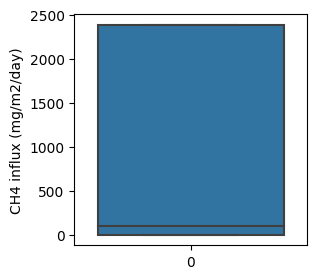

In [ ]:
fig, axes=plt.subplots(figsize=(3,3))
sns.boxplot(auto_fluxes_burned['methane_influx_mol/(m**2*s)'] * 16.04 * 1000 * 86400)
plt.ylabel('CH4 influx (mg/m2/day)')
plt.xlabel

In [ ]:
auto_fluxes_burned_melt = pd.melt(auto_fluxes_burned, id_vars=['Date'])

In [ ]:
auto_fluxes_burned_melt['var_b'] = ''
auto_fluxes_burned_melt['var_c'] = ''

auto_fluxes_burned_melt.loc[(auto_fluxes_burned_melt['variable'] == 'methane_ebul_mg/(m**2*day)') | 
                            (auto_fluxes_burned_melt['variable'] == 'mg_m2_d_ebul_ch4'), 'var_b'] = 'CH4 ebullition'

auto_fluxes_burned_melt.loc[(auto_fluxes_burned_melt['variable'] == 'methane_turb_flux_mg/(m**2*day)') | 
                            (auto_fluxes_burned_melt['variable'] == 'mg_m2_d_diff_ch4'), 'var_b'] = 'CH4 diffusion'

auto_fluxes_burned_melt.loc[(auto_fluxes_burned_melt['variable'] == 'co2_turb_flux_mg/(m**2*day)') | 
                            (auto_fluxes_burned_melt['variable'] == 'mg_m2_d_diff_co2'), 'var_b'] = 'CO2 diffusion'

auto_fluxes_burned_melt.loc[(auto_fluxes_burned_melt['variable'] == 'methane_ebul_mg/(m**2*day)') | 
                            (auto_fluxes_burned_melt['variable'] == 'methane_turb_flux_mg/(m**2*day)') |
                            (auto_fluxes_burned_melt['variable'] == 'co2_turb_flux_mg/(m**2*day)'), 'var_c'] = 'modeled'

auto_fluxes_burned_melt.loc[(auto_fluxes_burned_melt['variable'] == 'mg_m2_d_ebul_ch4') | 
                            (auto_fluxes_burned_melt['variable'] == 'mg_m2_d_diff_ch4') |
                            (auto_fluxes_burned_melt['variable'] == 'mg_m2_d_diff_co2'), 'var_c'] = 'observed'

In [ ]:
auto_fluxes_burned.columns

Index(['Unnamed: 0', 'pond', 'chamber', 'Date', 'slope_ppm_hr_ch4', 'r2_ch4',
       'air_temp_diff_ch4', 'sur_wat_temp_diff_ch4', 'umol_m2_hr_diff_ch4',
       'umol_m2_d_diff_ch4', 'mg_m2_d_diff_ch4', 'air_temp_ebul_ch4',
       'sur_wat_temp_ebul_ch4', 'umol_m2_hr_ebul_ch4', 'umol_m2_d_ebul_ch4',
       'mg_m2_d_ebul_ch4', 'slope_ppm_hr_co2', 'r2_co2', 'air_temp_diff_co2',
       'sur_wat_temp_diff_co2', 'umol_m2_hr_diff_co2', 'umol_m2_d_diff_co2',
       'mg_m2_d_diff_co2', 'air_temp_ebul_co2', 'sur_wat_temp_ebul_co2',
       'umol_m2_hr_ebul_co2', 'umol_m2_d_ebul_co2', 'mg_m2_d_ebul_co2', 'doy',
       'ddmm', 'Year', 'methane_ebul_mg/(m**2*day)',
       'methane_turb_flux_mg/(m**2*day)', 'co2_turb_flux_mg/(m**2*day)',
       'methane_influx_mol/(m**2*s)'],
      dtype='object')

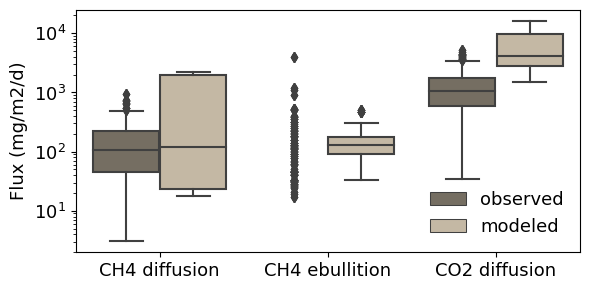

In [ ]:
palette= sns.color_palette(['#786F5F', '#C9BA9F'])

fig, axes = plt.subplots(figsize=(6,3))

sns.boxplot(data=auto_fluxes_burned_melt.loc[(auto_fluxes_burned_melt['var_b'] == 'CH4 ebullition') | 
                                             (auto_fluxes_burned_melt['var_b'] == 'CH4 diffusion') | 
                                             (auto_fluxes_burned_melt['var_b'] == 'CO2 diffusion')], 
            x='var_b', y='value', hue='var_c', palette=palette, ax=axes)
#sns.stripplot(data=auto_fluxes_burned_melt.loc[(auto_fluxes_burned_melt['var_b'] == 'CH4 ebullition') | 
#                                             (auto_fluxes_burned_melt['var_b'] == 'CH4 diffusion') | 
#                                             (auto_fluxes_burned_melt['var_b'] == 'CO2 diffusion')], 
#            x='var_b', y='value', hue='var_c', dodge=True, marker="o", edgecolor="black", 
#            linewidth=1, legend=False, palette=palette, ax=axes, alpha=0.1)

L=axes.legend(frameon=False, fontsize=13)
#L.get_texts()[0].set_text('modeled')
#L.get_texts()[1].set_text('observed')

axes.set_ylabel(u'Flux (mg/m2/d)', fontsize=13)
axes.set_xlabel('')
axes.tick_params(axis='both', which='major', labelsize=13)
plt.yscale("log")

fig.tight_layout()

plt.savefig('YKD_benchmark/figs/Flux_box_plots.jpg', dpi=300)

In [ ]:
# Generate box plot data for water sample comparisons
burned_sample_comp = burned_vars_df.loc[(~burned_vars_df['CH4_mol_m3'].isna()) & (burned_vars_df['depth']==-1)][['Date', 'ch4_water', 'o2_water', 'DO_mg_L', 'CH4_mol_m3', 'depth']].groupby(by='Date').mean()
unburned_sample_comp = unburned_vars_df.loc[(~unburned_vars_df['CH4_mol_m3'].isna()) & (unburned_vars_df['depth']==-1)][['Date', 'ch4_water', 'o2_water', 'DO_mg_L', 'CH4_mol_m3', 'depth']].groupby(by='Date').mean()
burned_sample_comp['pond'] = 'burned' 
unburned_sample_comp['pond'] = 'unburned'
sample_comp = pd.concat([burned_sample_comp, unburned_sample_comp]).reset_index()
sample_comp_melt=pd.melt(sample_comp, id_vars=['Date', 'pond'])

In [ ]:
burned_methane_df['methane_prod_young_mg/(m**2*day)'] = burned_methane_df['methane_prod_young_mol/(m**2*s)'] * 16.04 * 1000 * 86400
unburned_methane_df['methane_prod_young_mg/(m**2*day)'] = unburned_methane_df['methane_prod_young_mol/(m**2*s)'] * 16.04 * 1000 * 86400

<Axes: xlabel='sample', ylabel='methane_prod_mg/(m**2*day)'>

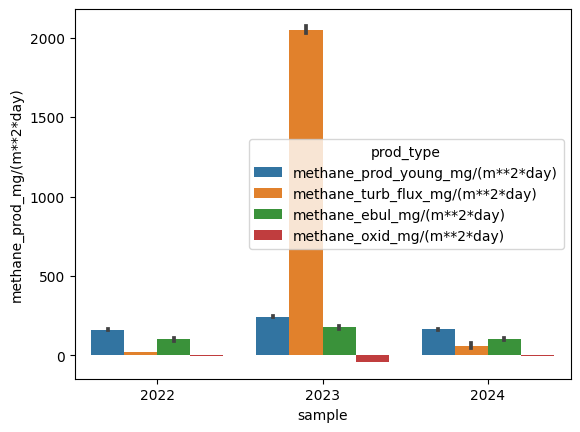

In [ ]:
burned_methane_df_melt = burned_methane_df.loc[burned_methane_df['Date'].dt.month==8].melt(id_vars=['sample', 'Date'], value_vars=['methane_prod_young_mg/(m**2*day)', 'methane_turb_flux_mg/(m**2*day)', 'methane_ebul_mg/(m**2*day)','methane_oxid_mg/(m**2*day)'], var_name='prod_type', value_name='methane_prod_mg/(m**2*day)')
sns.barplot(data=burned_methane_df_melt[burned_methane_df_melt['sample'].isin(ch4_top_10['sample'])], x='sample', y='methane_prod_mg/(m**2*day)', hue='prod_type')

<Axes: xlabel='sample', ylabel='methane_prod_mg/(m**2*day)'>

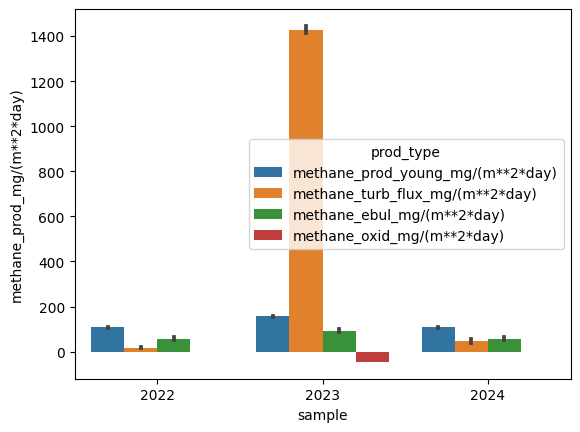

In [ ]:
unburned_methane_df_melt = unburned_methane_df.loc[unburned_methane_df['Date'].dt.month==8].melt(id_vars=['sample', 'Date'], value_vars=['methane_prod_young_mg/(m**2*day)', 'methane_turb_flux_mg/(m**2*day)', 'methane_ebul_mg/(m**2*day)','methane_oxid_mg/(m**2*day)'], var_name='prod_type', value_name='methane_prod_mg/(m**2*day)')
sns.barplot(data=unburned_methane_df_melt[unburned_methane_df_melt['sample'].isin(ch4_top_10['sample'])], x='sample', y='methane_prod_mg/(m**2*day)', hue='prod_type')

# Parameter sensitivity plots

In [ ]:
burned_vars_df['sample'].unique()

array([2022, 2023, 2024])

In [ ]:
burned_vars_df = burned_vars_df.replace(-999, np.nan)
burned_run_summary = burned_vars_df[['sample', 't_water', 'co2_water', 'ch4_water', 'o2_water', 'prodox', 'doc_water', 'pocl_water', 'phosph_water', 'chla']].groupby(by='sample').mean().reset_index()
burned_sensitivity_df = pd.merge(burned_run_summary, burned_sample_matrix, on='sample')

unburned_vars_df = unburned_vars_df.replace(-999, np.nan)
unburned_run_summary = unburned_vars_df[['sample', 't_water', 'co2_water', 'ch4_water', 'o2_water', 'prodox', 'doc_water', 'pocl_water', 'phosph_water']].groupby(by='sample').mean().reset_index()
unburned_sensitivity_df = pd.merge(unburned_run_summary, unburned_sample_matrix, on='sample')

/home/amullen/anaconda3/envs/lake_modeling/lib/python3.11/site-packages/seaborn/axisgrid.py:1310: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



KeyError: "['r0methprod'] not in index"

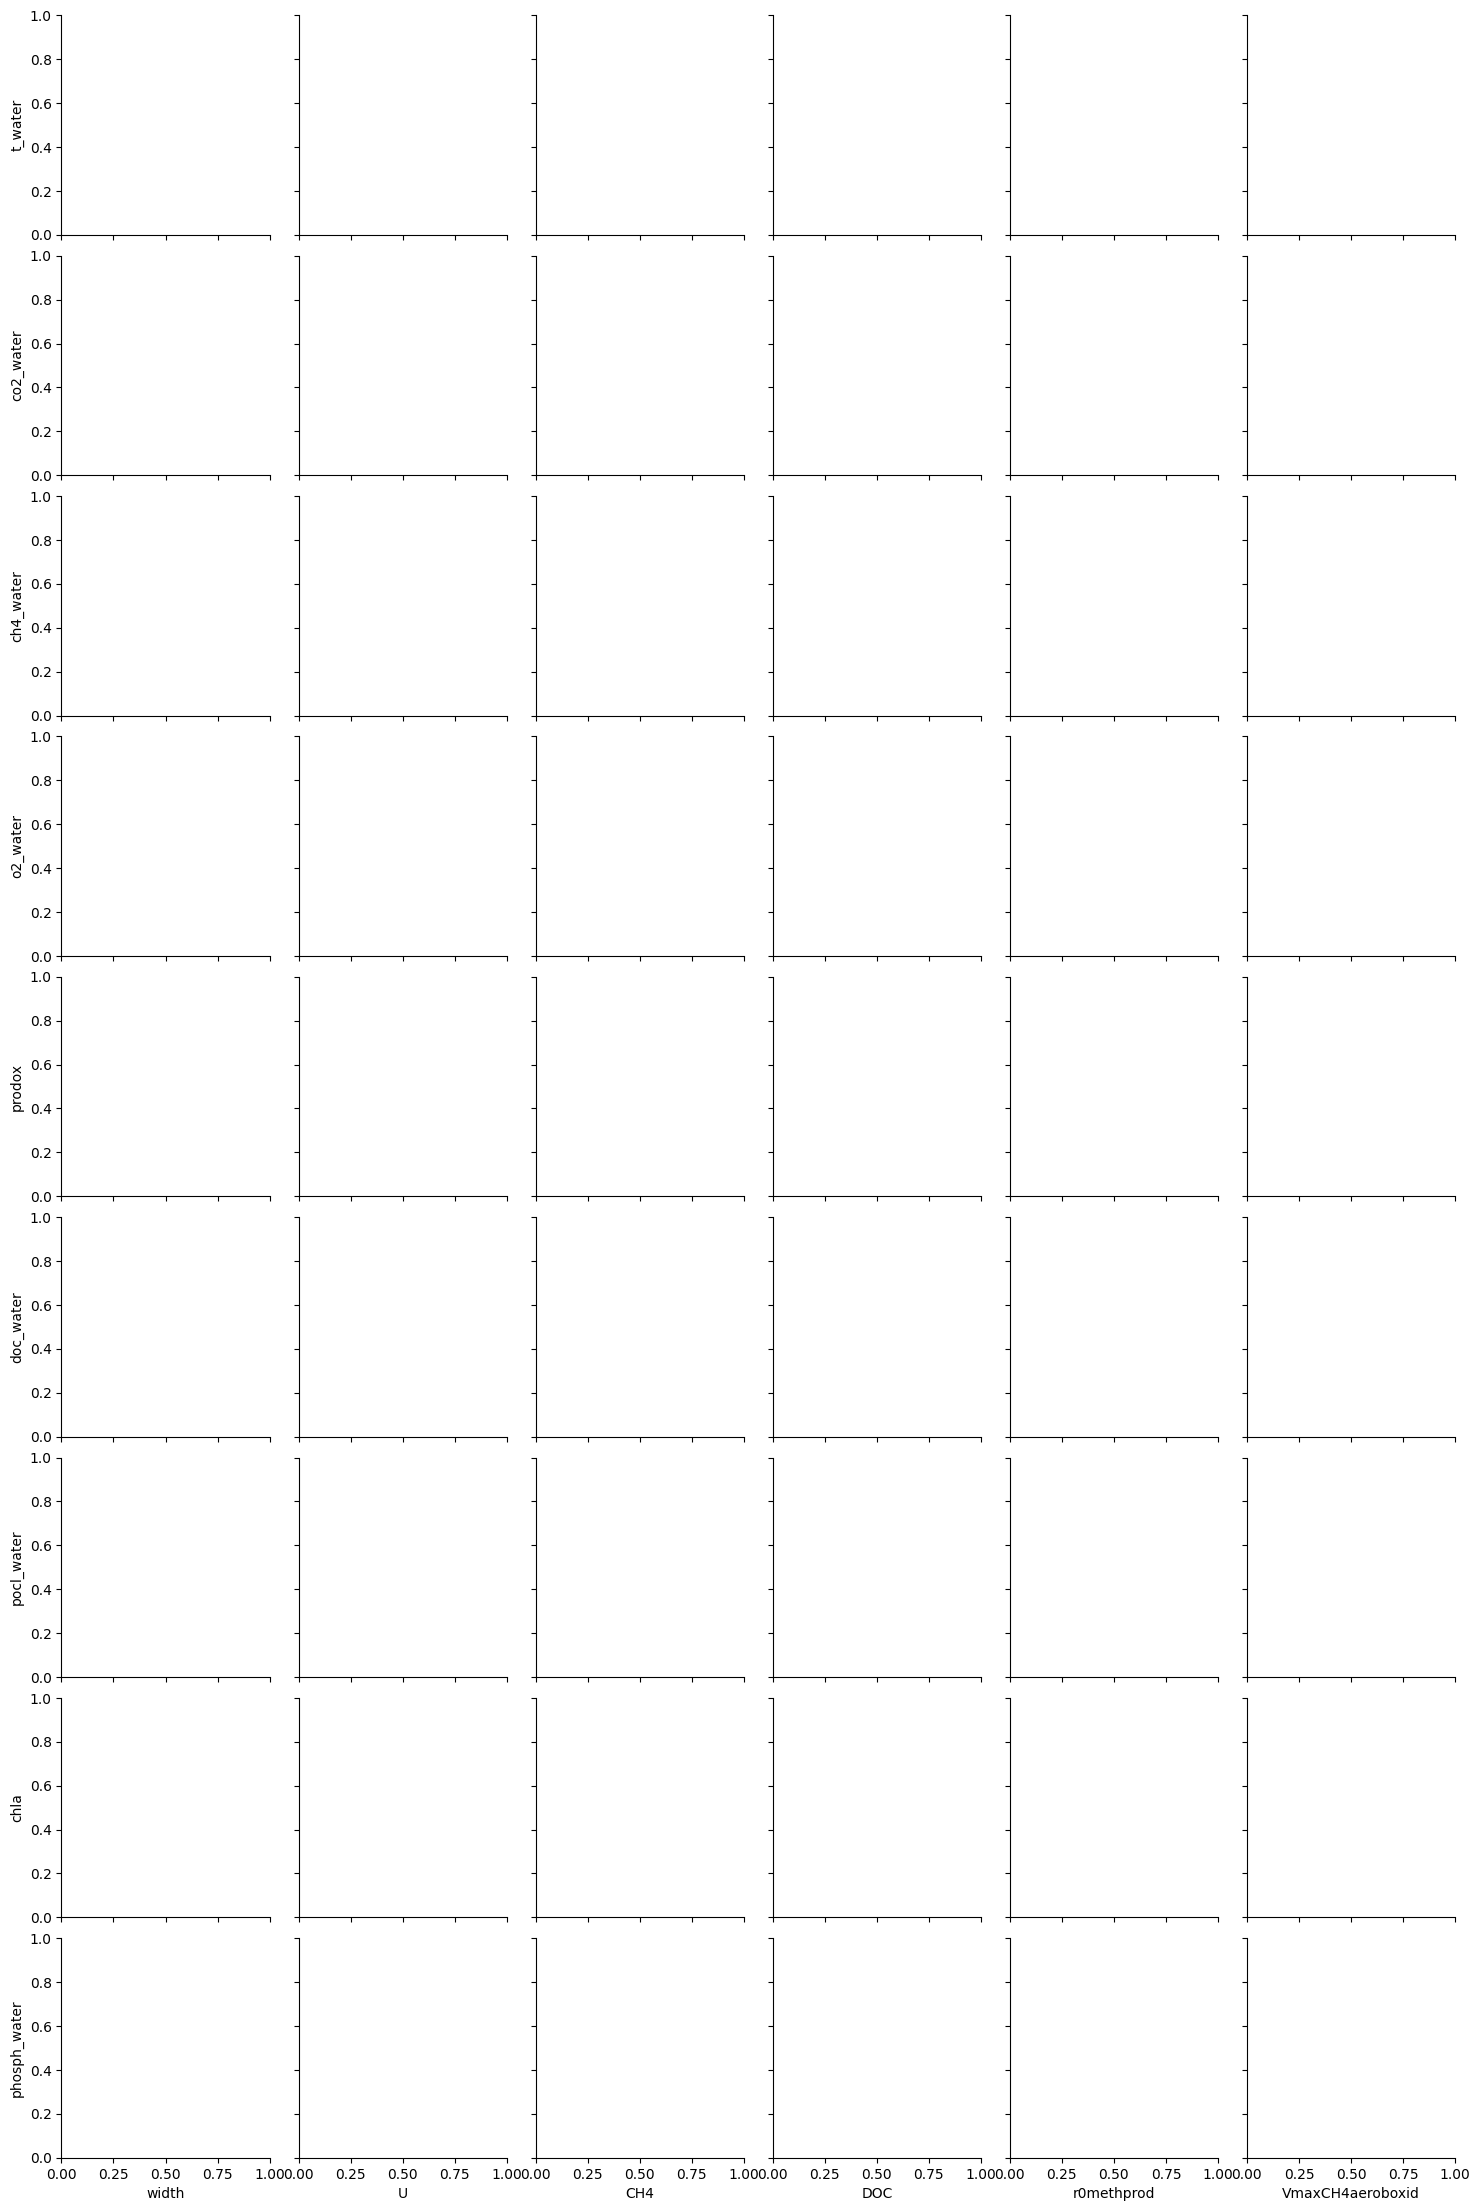

In [ ]:
sns.pairplot(burned_sensitivity_df, x_vars=['width','U', 'CH4', 'DOC', 'r0methprod', 'VmaxCH4aeroboxid'], y_vars=['t_water', 'co2_water', 'ch4_water', 'o2_water', 'prodox', 'doc_water', 'pocl_water', 'chla', 'phosph_water']) 

/home/amullen/anaconda3/envs/lake_modeling/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



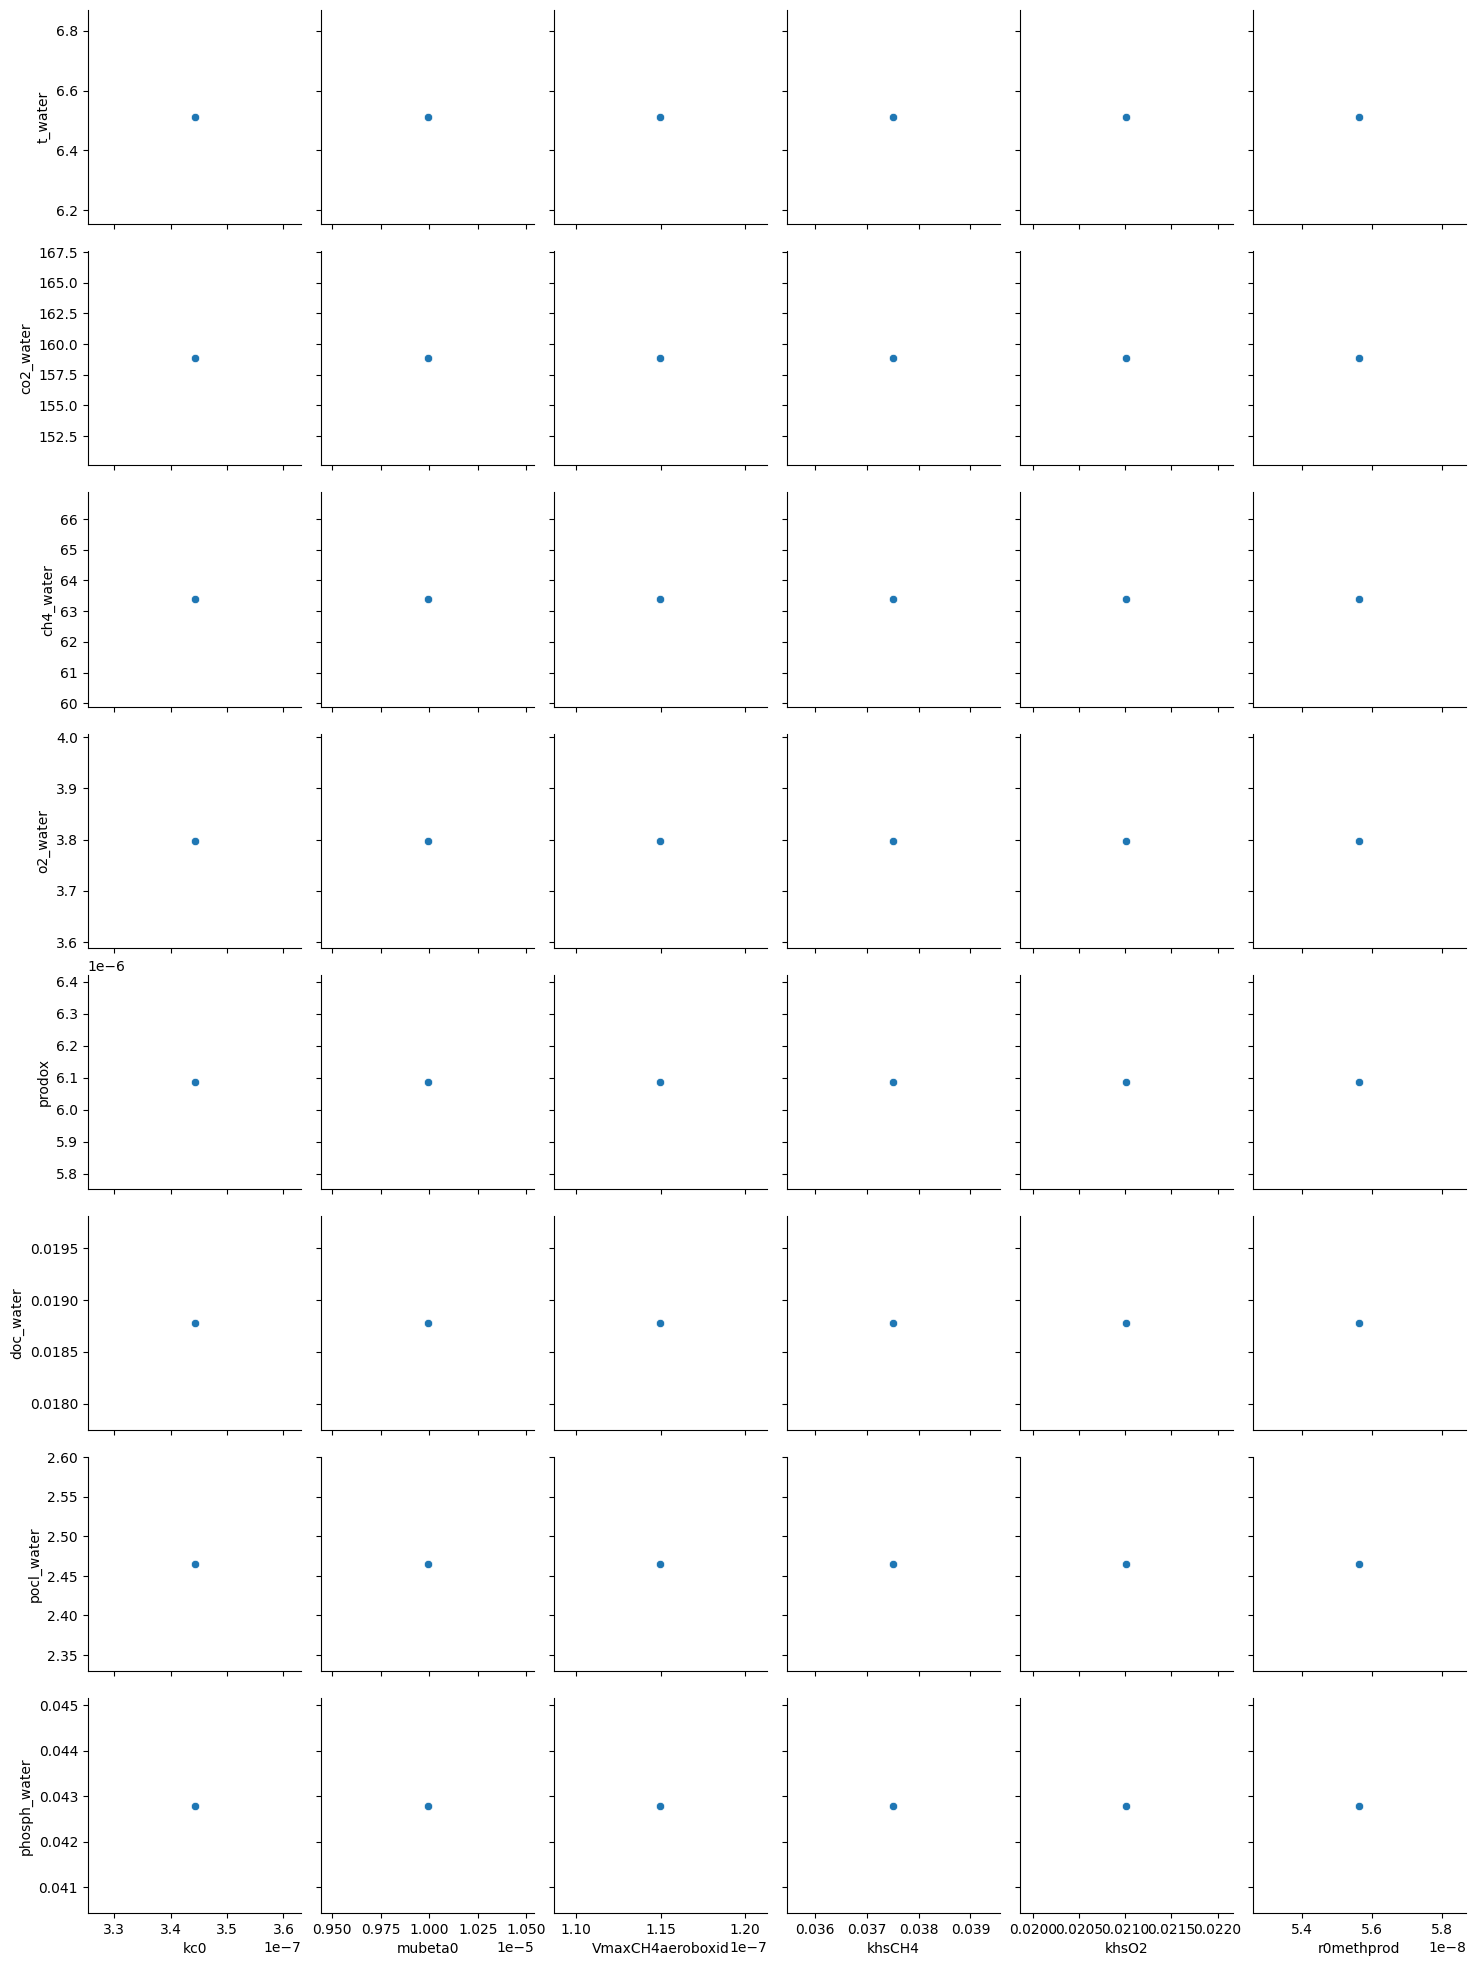

In [ ]:
sns.pairplot(unburned_sensitivity_df, x_vars=['kc0', 'mubeta0', 'VmaxCH4aeroboxid', 'khsCH4', 'khsO2', 'r0methprod'], 
             y_vars=['t_water', 'co2_water', 'ch4_water', 'o2_water','prodox', 'doc_water', 'pocl_water', 'phosph_water'])


In [ ]:
corr=unburned_sensitivity_df.corr()

corr= corr.drop(columns=['run_name', 't_water', 'co2_water', 'ch4_water', 'o2_water', 'prodox', 'doc_water', 'pocl_water'])
corr = corr.loc[['t_water', 'co2_water', 'ch4_water', 'o2_water', 'prodox', 'doc_water', 'pocl_water']]

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig, ax = plt.subplots(figsize=(5,5))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,annot=False,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
fig.tight_layout()
plt.savefig('YKD-SA/figures/corr_plot_unburned.jpg', dpi=300)

KeyError: "['run_name'] not found in axis"

# show top performing parameter values

In [ ]:
burned_sensitivity_df.loc[burned_sensitivity_df['run_name'].isin(co2_top['run_name'])]

,run_name,t_water,co2_water,ch4_water,o2_water,prodox,doc_water,pocl_water,phosph_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
0,0,13.815273,55.385211,20.461723,9.106401,0.000005,0.013996,2.459614,0.005256,4.507214e-07,0.000002,6.349597e-09,0.009343,0.011265,4.506958e-07


In [ ]:
burned_sensitivity_df.loc[burned_sensitivity_df['run_name'].isin(ch4_top['run_name'])]

,run_name,t_water,co2_water,ch4_water,o2_water,prodox,doc_water,pocl_water,phosph_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
0,0,13.815273,55.385211,20.461723,9.106401,0.000005,0.013996,2.459614,0.005256,4.507214e-07,0.000002,6.349597e-09,0.009343,0.011265,4.506958e-07


In [ ]:
burned_sensitivity_df.loc[burned_sensitivity_df['run_name'].isin(o2_top['run_name'])]

,run_name,t_water,co2_water,ch4_water,o2_water,prodox,doc_water,pocl_water,phosph_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
4,4,13.815273,55.404203,20.462339,9.105747,0.000005,0.014008,2.461699,0.005257,4.546262e-07,0.000002,3.227368e-07,0.009021,0.01324,4.525276e-07


In [ ]:
unburned_sensitivity_df.loc[unburned_sensitivity_df['run_name'].isin(co2_top_ub['run_name'])]

,run_name,t_water,co2_water,ch4_water,o2_water,prodox,doc_water,pocl_water,phosph_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
0,0,13.735675,114.81458,288.236071,6.649973,0.000006,0.003557,2.305027,0.006977,3.364315e-07,0.000017,2.533505e-11,0.006783,1.528162e-08,1.119792e-07


In [ ]:
unburned_sensitivity_df.loc[unburned_sensitivity_df['run_name'].isin(ch4_top_ub['run_name'])]

,run_name,t_water,co2_water,ch4_water,o2_water,prodox,doc_water,pocl_water,phosph_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
0,0,13.735675,114.81458,288.236071,6.649973,0.000006,0.003557,2.305027,0.006977,3.364315e-07,0.000017,2.533505e-11,0.006783,1.528162e-08,1.119792e-07


In [ ]:
unburned_sensitivity_df.loc[unburned_sensitivity_df['run_name'].isin(o2_top_ub['run_name'])]

,run_name,t_water,co2_water,ch4_water,o2_water,prodox,doc_water,pocl_water,phosph_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
0,0,13.735675,114.81458,288.236071,6.649973,0.000006,0.003557,2.305027,0.006977,3.364315e-07,0.000017,2.533505e-11,0.006783,1.528162e-08,1.119792e-07
